<h1 align="center"> INF6804 Lab 2: BRIEF descriptor </h1>
<br>
<h3 align="center"> Daniel Wang, Oumayma Messoussi </h3>
<br>

In [8]:
import numpy as np
from skimage import data, io
from skimage.feature import BRIEF, corner_peaks, corner_fast, match_descriptors, plot_matches
import matplotlib.pyplot as plt
from sgm import *
import glob

### BRIEF descriptor on KITTI dataset

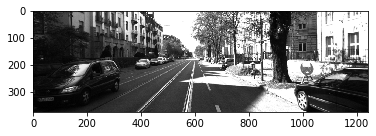

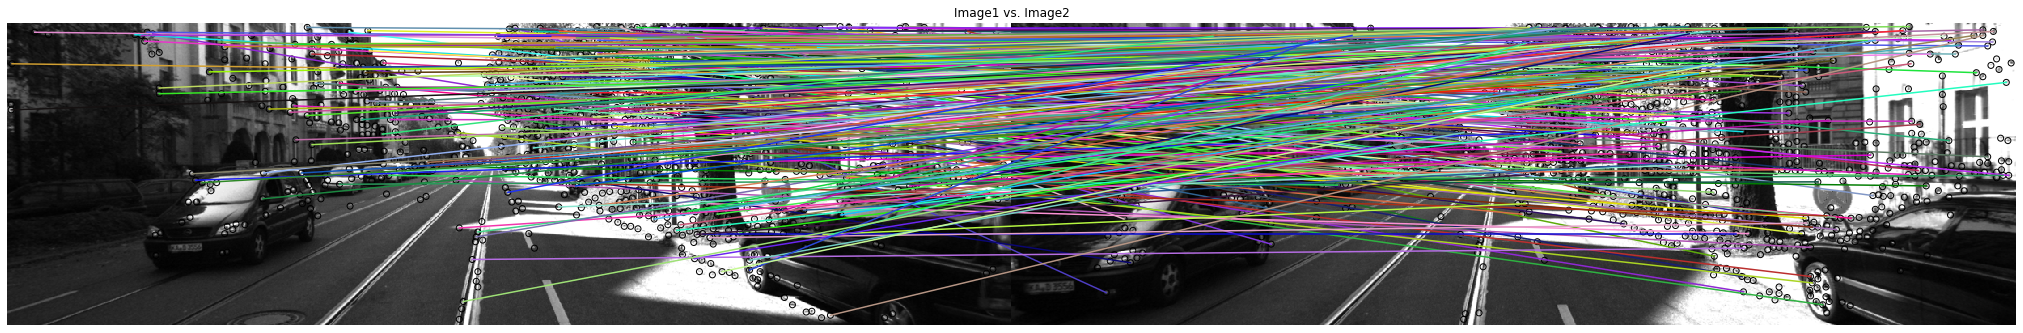

In [9]:
# source: https://github.com/gabilodeau/INF6804/blob/master/Descripteur%20BRIEF.ipynb

img1 = io.imread('KITTI/data_scene_flow/training/image_2/000000_10.png', as_gray= True)
img2 = io.imread('KITTI/data_scene_flow/training/image_2/000000_11.png', as_gray= True)
plt.imshow(img2, cmap='gray')
plt.show()

# extracting key points

kps1 = corner_peaks(corner_fast(img1), min_distance=5)
kps2 = corner_peaks(corner_fast(img2), min_distance=5)

# BRIEF descriptor

extractor = BRIEF(descriptor_size=128, patch_size=5, mode='normal')

extractor.extract(img1, kps1)
descriptor1 = extractor.descriptors
extractor.extract(img2, kps2)
descriptor2 = extractor.descriptors

# matching

matches = match_descriptors(descriptor1, descriptor2, cross_check=True)

# visualization

fig = plt.figure(figsize=(36, 20))
ax0 = plt.subplot()
plot_matches(ax0, img1, img2, kps1, kps2, matches)
ax0.axis('off')
ax0.set_title("Image1 vs. Image2")
plt.show()

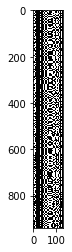

In [10]:
plt.imshow(descriptor1, cmap='gray')
plt.show()

In [11]:
desc1 = np.ndarray((descriptor1.shape[0],1), dtype=np.int64)

for i in range(descriptor1.shape[0]):
    #descriptorL[i, 0] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
    desc1[i] = np.int64(descriptor1[i].dot(2**np.arange(descriptor1[i].size)[::-1]))
np.amax(desc1)

2144454986

### SGM disparity estimation

In [12]:
# Source: https://github.com/beaupreda/semi-global-matching (with modification)
    
def compute_costs(left_descriptor, right_descriptor, parameters, save_images):
    
    """ 
    first step of the sgm algorithm
    :param left: left descriptor
    :param right: right descriptor
    :param parameters: structure containing parameters of the algorithm
    :param save_images: whether to save census images or not
    :return: H x W x D array with the matching costs 
    """
    
    disparity = parameters.max_disparity
    
    print('\tComputing cost volume...', end='')
    height = left_descriptor.shape[0]
    width = left_descriptor.shape[1]
    x_offset = int(disparity / 2)
    sys.stdout.flush()
    dawn = t.time()

    left_cost_volume = np.zeros(shape=(height, width, disparity), dtype=left_descriptor.dtype)
    rvalues = np.zeros(shape=right_descriptor.shape, dtype=right_descriptor.dtype)
    for d in range(0, disparity):
        rvalues[:, (x_offset + d):(width - x_offset)] = right_descriptor[:, x_offset:(width - d - x_offset)]
        dist = distances.hamming_distance(left_descriptor, rvalues)
        left_cost_volume[:, :, d] = dist

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_cost_volume

In [13]:
def get_recall(disparity, gt, disp):
    """
    computes the recall of the disparity map
    :param disparity: disparity image
    :param gt: path to ground-truth image
    :param args: program arguments
    :return: rate of correct predictions
    """
    gt = np.float32(cv2.imread(gt, cv2.IMREAD_GRAYSCALE))
    gt = gt[1:gt.shape[0]-1, 1:gt.shape[1]-1]
    gt = np.int16(gt / 255.0 * float(disp))
    disparity = np.int16(np.float32(disparity) / 255.0 * float(disp))
    correct = np.count_nonzero(np.abs(disparity - gt) <= 3)
    return float(correct) / gt.size

In [14]:
def sgm(descriptorL, descriptorR, basename, gt1, gt2):
    """
    main function applying the semi-global matching algorithm
    :return: void
    """

    disparity = 64
    save_images = False
    evaluation = True
    output_name = basename
    left_gt_name = gt1
    right_gt_name = gt2

    #dawn = t.time()

    parameters = Parameters(max_disparity=disparity, P1=10, P2=120, csize=(7, 7), bsize=(3, 3))
    paths = Paths()

    print('\nStarting cost computation...')
    left_cost_volume = compute_costs(descriptorL, descriptorR, parameters, save_images)

    print('\nStarting left aggregation computation...')
    left_aggregation_volume = aggregate_costs(left_cost_volume, parameters, paths)
    #print('\nStarting right aggregation computation...')
    #right_aggregation_volume = aggregate_costs(right_cost_volume, parameters, paths)

    print('\nSelecting best disparities...')
    left_disparity_map = np.uint8(normalize(select_disparity(left_aggregation_volume), parameters))
    #right_disparity_map = np.uint8(normalize(select_disparity(right_aggregation_volume), parameters))
    if save_images:
        cv2.imwrite('left_disp_map_no_post_processing.png', left_disparity_map)
        #cv2.imwrite('right_disp_map_no_post_processing.png', right_disparity_map)

    print('\nApplying median filter...')
    left_disparity_map = cv2.medianBlur(left_disparity_map, parameters.bsize[0])
    #right_disparity_map = cv2.medianBlur(right_disparity_map, parameters.bsize[0])
    cv2.imwrite(f'left_disp_{output_name}', left_disparity_map)
    #cv2.imwrite(f'right_disp_{output_name}', right_disparity_map)

    if evaluation:
        print('\nEvaluating left disparity map...')
        left_recall = get_recall(left_disparity_map, left_gt_name, disparity)
        print('\tRecall left= {:.2f}%'.format(left_recall * 100.0))
        #print('\nEvaluating right disparity map...')
        #right_recall = get_recall(right_disparity_map, right_gt_name, disparity)
        #print('\tRecall right= {:.2f}%'.format(right_recall * 100.0))

    #dusk = t.time()
    #print('\nFin.')
    #print('\nTotal execution time = {:.2f}s'.format(dusk - dawn))
    
    return left_disparity_map, left_recall

## KITTI dataset evaluation: moving camera

In [16]:
# stereo = cv2.StereoSGBM_create(
#     minDisparity=0,
#     numDisparities=160,
#     blockSize=1,
#     P1=8 * 3 * 3 ** 2,
#     P2=32 * 3 * 3 ** 2,
#     disp12MaxDiff=1,
#     uniquenessRatio=15,
#     speckleWindowSize=0,
#     speckleRange=2,
#     preFilterCap=63,
#     mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
# )

save_recall = []

for image1, image2, gt1, gt2 in zip(glob.glob('KITTI/data_scene_flow/training/image_2/00000[0-9]_10.png'),
                                      glob.glob('KITTI/data_scene_flow/training/image_2/00000[0-9]_11.png'),
                                      glob.glob('KITTI/data_scene_flow/training/disp_noc_0/00000[0-9]_10.png'),
                                      glob.glob('KITTI/data_scene_flow/training/disp_noc_1/00000[0-9]_10.png')):
    
    dawn = t.time()
    
    imgL = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)
    gtL = cv2.imread(gt1, cv2.IMREAD_GRAYSCALE)
    gtR = cv2.imread(gt2, cv2.IMREAD_GRAYSCALE)
    
    print(np.amax(imgL))
    
    # matrix indices to use as "key points"

    indicesL = np.zeros(((imgL.shape[0])*(imgL.shape[1]), 2), dtype=np.int64)
    indicesR = np.zeros(((imgR.shape[0])*(imgR.shape[1]), 2), dtype=np.int64)
    
    k = 0
    for i in range(0, imgL.shape[0]):
        for j in range(0, imgL.shape[1]):
            indicesL[k,0], indicesL[k,1] = i, j
            k += 1
    k = 0
    for i in range(0, imgR.shape[0]):
        for j in range(0, imgR.shape[1]):
            indicesR[k,0], indicesR[k,1] = i, j
            k += 1

    # BRIEF descriptor

    extractor = BRIEF(descriptor_size=128, patch_size=7)
    #brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
   
    extractor.extract(imgL, indicesL)
    descriptorL = extractor.descriptors
    extractor.extract(imgR, indicesR)
    descriptorR = extractor.descriptors
    
#     indicesL, descriptorL = brief.compute(imgL, indicesL)
#     indicesR, descriptorR = brief.compute(imgR, indicesR)

    print(descriptorL.shape)
    print(np.amax(descriptorL))
    
    descL = np.ndarray((descriptorL.shape[0],1), dtype=np.int64)
    descR = np.ndarray((descriptorR.shape[0],1), dtype=np.int64)

    for i in range(descriptorL.shape[0]):
        #descriptorL[i, 0] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
        descL[i] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
        
    for i in range(descriptorR.shape[0]):
        #descriptorR[i, 0] = descriptorR[i].dot(2**np.arange(descriptorR[i].size)[::-1])
        descR[i] = descriptorR[i].dot(2**np.arange(descriptorR[i].size)[::-1])
    
    print(descL.shape)
    print(np.amax(descL))
    
    descriptorL = descL.reshape((373, 1240))
    descriptorR = descR.reshape((373, 1240))
    
    print(descriptorL.shape)
    print(np.amax(descriptorL))

    # SGM matching
    
    print('Computing disparity...')
    
    left_disparity_map, left_recall = sgm(descriptorL, descriptorR, image1.split('/')[3].split('\\')[1], gt1, gt2)
    #disparity = stereo.compute(descriptorL.astype(np.uint8), descriptorR.astype(np.uint8)).astype(np.float32)/16
    
    left_disparity_norm = np.ndarray((left_disparity_map.shape[0], left_disparity_map.shape[1]))
    #right_disparity_norm = np.ndarray((right_disparity_map.shape[0], right_disparity_map.shape[1]))

    left_disparity_norm = cv2.normalize(src=left_disparity_map, dst=left_disparity_norm, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    #right_disparity_norm = cv2.normalize(src=right_disparity_map, dst=right_disparity_norm, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    
    save_recall.append(left_recall)
    
    # Visualization
    
#     fig = plt.figure(figsize=(200, 200))
            
#     x = fig.add_subplot(1,2, 1)
#     x.set_title('imgL')
#     plt.imshow(imgL, cmap='gray')

#     y = fig.add_subplot(1,2, 2)
#     y.set_title('imgR')
#     plt.imshow(imgR, cmap='gray')
    
#     plt.show()
    
    fig = plt.figure(figsize=(200, 200))
    
    x = fig.add_subplot(1,2, 1)
    x.set_title('gt')
    plt.imshow(gtL, cmap='gray')

    y = fig.add_subplot(1,2, 2)
    y.set_title('disparity map')
    plt.imshow(left_disparity_norm, cmap='gray')

    plt.show()
    
    dusk = t.time()
    print('\nImage '+image1+' processing finished.')
    print('\nTotal execution time = {:.2f}s'.format(dusk - dawn))
    print('\n-------------------------------\n')

255


IndexError: index 462520 is out of bounds for axis 0 with size 462520

In [22]:
np.amax(left_disparity_norm)

0

In [23]:
left_disparity_map.shape

(373, 1240)

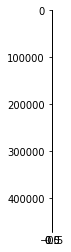

In [22]:
plt.imshow(descL, cmap='gray')
plt.show()

## Middlebury dataset evaluation: occlusions and challenging geometric shapes

In [6]:
# stereo = cv2.StereoSGBM_create(
#     minDisparity=0,
#     numDisparities=160,
#     blockSize=1,
#     P1=8 * 3 * 3 ** 2,
#     P2=32 * 3 * 3 ** 2,
#     disp12MaxDiff=1,
#     uniquenessRatio=15,
#     speckleWindowSize=0,
#     speckleRange=2,
#     preFilterCap=63,
#     mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
# )

save_recall = []

for image1, image2, gt1, gt2 in zip(glob.glob('Middlebury/cones/im2.ppm'),
                                      glob.glob('Middlebury/cones/im6.ppm'),
                                      glob.glob('Middlebury/cones/disp2.pgm'),
                                      glob.glob('Middlebury/cones/disp6.pgm')):
    
    dawn = t.time()
    
    imgL = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)
    gtL = cv2.imread(gt1, cv2.IMREAD_GRAYSCALE)
    gtR = cv2.imread(gt2, cv2.IMREAD_GRAYSCALE)
    
    print(np.amax(imgL))
    
    # matrix indices to use as "key points"

    indicesL = np.zeros(((imgL.shape[0]-2)*(imgL.shape[1]-2), 2), dtype=np.int64)
    indicesR = np.zeros(((imgR.shape[0]-2)*(imgR.shape[1]-2), 2), dtype=np.int64)
    
    k = 0
    for i in range(1, imgL.shape[0]-1):
        for j in range(1, imgL.shape[1]-1):
            indicesL[k,0], indicesL[k,1] = i, j
            k += 1
    k = 0
    for i in range(1, imgR.shape[0]-1):
        for j in range(1, imgR.shape[1]-1):
            indicesR[k,0], indicesR[k,1] = i, j
            k += 1
    
    # BRIEF descriptor

    extractor = BRIEF(descriptor_size=64, patch_size=3)
    #brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
   
    extractor.extract(imgL, indicesL)
    descriptorL = extractor.descriptors
    extractor.extract(imgR, indicesR)
    descriptorR = extractor.descriptors
    
#     indicesL, descriptorL = brief.compute(imgL, indicesL)
#     indicesR, descriptorR = brief.compute(imgR, indicesR)

    print(descriptorL.shape)
    print(np.amax(descriptorL))
    
    descL = np.ndarray((descriptorL.shape[0],1), dtype=np.int64)
    descR = np.ndarray((descriptorR.shape[0],1), dtype=np.int64)

    for i in range(descriptorL.shape[0]):
        #descriptorL[i, 0] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
        descL[i] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
        
    for i in range(descriptorR.shape[0]):
        #descriptorR[i, 0] = descriptorR[i].dot(2**np.arange(descriptorR[i].size)[::-1])
        descL[i] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
    
    print(descL.shape)
    print(np.amax(descL))
    
    descriptorL = descL.reshape((imgL.shape[0]-2, imgL.shape[1]-2))
    descriptorR = descL.reshape((imgR.shape[0]-2, imgR.shape[1]-2))
    
    print(descriptorL.shape)
    print(np.amax(descriptorL))

    # SGM matching
    
    print('Computing disparity...')
    
    left_disparity_map, left_recall = sgm(descriptorL, descriptorR, image1.split('/')[2], gt1, gt2)
    #disparity = stereo.compute(descriptorL.astype(np.uint8), descriptorR.astype(np.uint8)).astype(np.float32)/16
    
    left_disparity_norm = np.ndarray((left_disparity_map.shape[0], left_disparity_map.shape[1]))
    #right_disparity_norm = np.ndarray((right_disparity_map.shape[0], right_disparity_map.shape[1]))

    left_disparity_norm = cv2.normalize(src=left_disparity_map, dst=left_disparity_norm, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    #right_disparity_norm = cv2.normalize(src=right_disparity_map, dst=right_disparity_norm, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    
    save_recall.append(left_recall)
    
    # Visualization
    
#     fig = plt.figure(figsize=(200, 200))
            
#     x = fig.add_subplot(1,2, 1)
#     x.set_title('imgL')
#     plt.imshow(imgL, cmap='gray')

#     y = fig.add_subplot(1,2, 2)
#     y.set_title('imgR')
#     plt.imshow(imgR, cmap='gray')
    
#     plt.show()
    
    fig = plt.figure(figsize=(100, 100))
    
    x = fig.add_subplot(1,2, 1)
    x.set_title('gt')
    plt.imshow(gtL, cmap='gray')

    y = fig.add_subplot(1,2, 2)
    y.set_title('disparity map')
    plt.imshow(left_disparity_norm, cmap='gray')

    plt.show()
    
    dusk = t.time()
    print('\nImage '+image1+' processing finished.')
    print('\nTotal execution time = {:.2f}s'.format(dusk - dawn))
    print('\n-------------------------------\n')

235
(167104, 64)
False
(167104, 1)
0
(373, 448)
0
Computing disparity...

Starting cost computation...
	Computing cost volume...	(done in 0.26s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 10.58s)
	Processing paths south-east and north-west...	(done in 10.44s)
	Processing paths south and north...	(done in 10.46s)
	Processing paths south-west and north-east...

KeyboardInterrupt: 

In [1]:
from experiments import * 

experiments()


Starting cost computation...
	Computing cost volume...	(done in 0.23s)

Starting aggregation computation...
	Processing paths east and west...	(done in 10.77s)
	Processing paths south-east and north-west...	(done in 10.90s)
	Processing paths south and north...	(done in 10.77s)
	Processing paths south-west and north-east...	(done in 11.02s)

Selecting best disparities...

Evaluating left disparity map...
	Recall = 3.21%


In [8]:
indicesL
for i in indicesL:
    print(i)

[1 1]
[1 2]
[1 3]
[1 4]
[1 5]
[1 6]
[1 7]
[1 8]
[1 9]
[ 1 10]
[ 1 11]
[ 1 12]
[ 1 13]
[ 1 14]
[ 1 15]
[ 1 16]
[ 1 17]
[ 1 18]
[ 1 19]
[ 1 20]
[ 1 21]
[ 1 22]
[ 1 23]
[ 1 24]
[ 1 25]
[ 1 26]
[ 1 27]
[ 1 28]
[ 1 29]
[ 1 30]
[ 1 31]
[ 1 32]
[ 1 33]
[ 1 34]
[ 1 35]
[ 1 36]
[ 1 37]
[ 1 38]
[ 1 39]
[ 1 40]
[ 1 41]
[ 1 42]
[ 1 43]
[ 1 44]
[ 1 45]
[ 1 46]
[ 1 47]
[ 1 48]
[ 1 49]
[ 1 50]
[ 1 51]
[ 1 52]
[ 1 53]
[ 1 54]
[ 1 55]
[ 1 56]
[ 1 57]
[ 1 58]
[ 1 59]
[ 1 60]
[ 1 61]
[ 1 62]
[ 1 63]
[ 1 64]
[ 1 65]
[ 1 66]
[ 1 67]
[ 1 68]
[ 1 69]
[ 1 70]
[ 1 71]
[ 1 72]
[ 1 73]
[ 1 74]
[ 1 75]
[ 1 76]
[ 1 77]
[ 1 78]
[ 1 79]
[ 1 80]
[ 1 81]
[ 1 82]
[ 1 83]
[ 1 84]
[ 1 85]
[ 1 86]
[ 1 87]
[ 1 88]
[ 1 89]
[ 1 90]
[ 1 91]
[ 1 92]
[ 1 93]
[ 1 94]
[ 1 95]
[ 1 96]
[ 1 97]
[ 1 98]
[ 1 99]
[  1 100]
[  1 101]
[  1 102]
[  1 103]
[  1 104]
[  1 105]
[  1 106]
[  1 107]
[  1 108]
[  1 109]
[  1 110]
[  1 111]
[  1 112]
[  1 113]
[  1 114]
[  1 115]
[  1 116]
[  1 117]
[  1 118]
[  1 119]
[  1 120]
[  1 121]
[  1 1

[ 6 32]
[ 6 33]
[ 6 34]
[ 6 35]
[ 6 36]
[ 6 37]
[ 6 38]
[ 6 39]
[ 6 40]
[ 6 41]
[ 6 42]
[ 6 43]
[ 6 44]
[ 6 45]
[ 6 46]
[ 6 47]
[ 6 48]
[ 6 49]
[ 6 50]
[ 6 51]
[ 6 52]
[ 6 53]
[ 6 54]
[ 6 55]
[ 6 56]
[ 6 57]
[ 6 58]
[ 6 59]
[ 6 60]
[ 6 61]
[ 6 62]
[ 6 63]
[ 6 64]
[ 6 65]
[ 6 66]
[ 6 67]
[ 6 68]
[ 6 69]
[ 6 70]
[ 6 71]
[ 6 72]
[ 6 73]
[ 6 74]
[ 6 75]
[ 6 76]
[ 6 77]
[ 6 78]
[ 6 79]
[ 6 80]
[ 6 81]
[ 6 82]
[ 6 83]
[ 6 84]
[ 6 85]
[ 6 86]
[ 6 87]
[ 6 88]
[ 6 89]
[ 6 90]
[ 6 91]
[ 6 92]
[ 6 93]
[ 6 94]
[ 6 95]
[ 6 96]
[ 6 97]
[ 6 98]
[ 6 99]
[  6 100]
[  6 101]
[  6 102]
[  6 103]
[  6 104]
[  6 105]
[  6 106]
[  6 107]
[  6 108]
[  6 109]
[  6 110]
[  6 111]
[  6 112]
[  6 113]
[  6 114]
[  6 115]
[  6 116]
[  6 117]
[  6 118]
[  6 119]
[  6 120]
[  6 121]
[  6 122]
[  6 123]
[  6 124]
[  6 125]
[  6 126]
[  6 127]
[  6 128]
[  6 129]
[  6 130]
[  6 131]
[  6 132]
[  6 133]
[  6 134]
[  6 135]
[  6 136]
[  6 137]
[  6 138]
[  6 139]
[  6 140]
[  6 141]
[  6 142]
[  6 143]
[  6 144]
[  6 1

[ 10 358]
[ 10 359]
[ 10 360]
[ 10 361]
[ 10 362]
[ 10 363]
[ 10 364]
[ 10 365]
[ 10 366]
[ 10 367]
[ 10 368]
[ 10 369]
[ 10 370]
[ 10 371]
[ 10 372]
[ 10 373]
[ 10 374]
[ 10 375]
[ 10 376]
[ 10 377]
[ 10 378]
[ 10 379]
[ 10 380]
[ 10 381]
[ 10 382]
[ 10 383]
[ 10 384]
[ 10 385]
[ 10 386]
[ 10 387]
[ 10 388]
[ 10 389]
[ 10 390]
[ 10 391]
[ 10 392]
[ 10 393]
[ 10 394]
[ 10 395]
[ 10 396]
[ 10 397]
[ 10 398]
[ 10 399]
[ 10 400]
[ 10 401]
[ 10 402]
[ 10 403]
[ 10 404]
[ 10 405]
[ 10 406]
[ 10 407]
[ 10 408]
[ 10 409]
[ 10 410]
[ 10 411]
[ 10 412]
[ 10 413]
[ 10 414]
[ 10 415]
[ 10 416]
[ 10 417]
[ 10 418]
[ 10 419]
[ 10 420]
[ 10 421]
[ 10 422]
[ 10 423]
[ 10 424]
[ 10 425]
[ 10 426]
[ 10 427]
[ 10 428]
[ 10 429]
[ 10 430]
[ 10 431]
[ 10 432]
[ 10 433]
[ 10 434]
[ 10 435]
[ 10 436]
[ 10 437]
[ 10 438]
[ 10 439]
[ 10 440]
[ 10 441]
[ 10 442]
[ 10 443]
[ 10 444]
[ 10 445]
[ 10 446]
[ 10 447]
[ 10 448]
[11  1]
[11  2]
[11  3]
[11  4]
[11  5]
[11  6]
[11  7]
[11  8]
[11  9]
[11 10]
[11 11]
[1

[16 96]
[16 97]
[16 98]
[16 99]
[ 16 100]
[ 16 101]
[ 16 102]
[ 16 103]
[ 16 104]
[ 16 105]
[ 16 106]
[ 16 107]
[ 16 108]
[ 16 109]
[ 16 110]
[ 16 111]
[ 16 112]
[ 16 113]
[ 16 114]
[ 16 115]
[ 16 116]
[ 16 117]
[ 16 118]
[ 16 119]
[ 16 120]
[ 16 121]
[ 16 122]
[ 16 123]
[ 16 124]
[ 16 125]
[ 16 126]
[ 16 127]
[ 16 128]
[ 16 129]
[ 16 130]
[ 16 131]
[ 16 132]
[ 16 133]
[ 16 134]
[ 16 135]
[ 16 136]
[ 16 137]
[ 16 138]
[ 16 139]
[ 16 140]
[ 16 141]
[ 16 142]
[ 16 143]
[ 16 144]
[ 16 145]
[ 16 146]
[ 16 147]
[ 16 148]
[ 16 149]
[ 16 150]
[ 16 151]
[ 16 152]
[ 16 153]
[ 16 154]
[ 16 155]
[ 16 156]
[ 16 157]
[ 16 158]
[ 16 159]
[ 16 160]
[ 16 161]
[ 16 162]
[ 16 163]
[ 16 164]
[ 16 165]
[ 16 166]
[ 16 167]
[ 16 168]
[ 16 169]
[ 16 170]
[ 16 171]
[ 16 172]
[ 16 173]
[ 16 174]
[ 16 175]
[ 16 176]
[ 16 177]
[ 16 178]
[ 16 179]
[ 16 180]
[ 16 181]
[ 16 182]
[ 16 183]
[ 16 184]
[ 16 185]
[ 16 186]
[ 16 187]
[ 16 188]
[ 16 189]
[ 16 190]
[ 16 191]
[ 16 192]
[ 16 193]
[ 16 194]
[ 16 195]
[ 16 196

[ 21 221]
[ 21 222]
[ 21 223]
[ 21 224]
[ 21 225]
[ 21 226]
[ 21 227]
[ 21 228]
[ 21 229]
[ 21 230]
[ 21 231]
[ 21 232]
[ 21 233]
[ 21 234]
[ 21 235]
[ 21 236]
[ 21 237]
[ 21 238]
[ 21 239]
[ 21 240]
[ 21 241]
[ 21 242]
[ 21 243]
[ 21 244]
[ 21 245]
[ 21 246]
[ 21 247]
[ 21 248]
[ 21 249]
[ 21 250]
[ 21 251]
[ 21 252]
[ 21 253]
[ 21 254]
[ 21 255]
[ 21 256]
[ 21 257]
[ 21 258]
[ 21 259]
[ 21 260]
[ 21 261]
[ 21 262]
[ 21 263]
[ 21 264]
[ 21 265]
[ 21 266]
[ 21 267]
[ 21 268]
[ 21 269]
[ 21 270]
[ 21 271]
[ 21 272]
[ 21 273]
[ 21 274]
[ 21 275]
[ 21 276]
[ 21 277]
[ 21 278]
[ 21 279]
[ 21 280]
[ 21 281]
[ 21 282]
[ 21 283]
[ 21 284]
[ 21 285]
[ 21 286]
[ 21 287]
[ 21 288]
[ 21 289]
[ 21 290]
[ 21 291]
[ 21 292]
[ 21 293]
[ 21 294]
[ 21 295]
[ 21 296]
[ 21 297]
[ 21 298]
[ 21 299]
[ 21 300]
[ 21 301]
[ 21 302]
[ 21 303]
[ 21 304]
[ 21 305]
[ 21 306]
[ 21 307]
[ 21 308]
[ 21 309]
[ 21 310]
[ 21 311]
[ 21 312]
[ 21 313]
[ 21 314]
[ 21 315]
[ 21 316]
[ 21 317]
[ 21 318]
[ 21 319]
[ 21 320]


[ 26 378]
[ 26 379]
[ 26 380]
[ 26 381]
[ 26 382]
[ 26 383]
[ 26 384]
[ 26 385]
[ 26 386]
[ 26 387]
[ 26 388]
[ 26 389]
[ 26 390]
[ 26 391]
[ 26 392]
[ 26 393]
[ 26 394]
[ 26 395]
[ 26 396]
[ 26 397]
[ 26 398]
[ 26 399]
[ 26 400]
[ 26 401]
[ 26 402]
[ 26 403]
[ 26 404]
[ 26 405]
[ 26 406]
[ 26 407]
[ 26 408]
[ 26 409]
[ 26 410]
[ 26 411]
[ 26 412]
[ 26 413]
[ 26 414]
[ 26 415]
[ 26 416]
[ 26 417]
[ 26 418]
[ 26 419]
[ 26 420]
[ 26 421]
[ 26 422]
[ 26 423]
[ 26 424]
[ 26 425]
[ 26 426]
[ 26 427]
[ 26 428]
[ 26 429]
[ 26 430]
[ 26 431]
[ 26 432]
[ 26 433]
[ 26 434]
[ 26 435]
[ 26 436]
[ 26 437]
[ 26 438]
[ 26 439]
[ 26 440]
[ 26 441]
[ 26 442]
[ 26 443]
[ 26 444]
[ 26 445]
[ 26 446]
[ 26 447]
[ 26 448]
[27  1]
[27  2]
[27  3]
[27  4]
[27  5]
[27  6]
[27  7]
[27  8]
[27  9]
[27 10]
[27 11]
[27 12]
[27 13]
[27 14]
[27 15]
[27 16]
[27 17]
[27 18]
[27 19]
[27 20]
[27 21]
[27 22]
[27 23]
[27 24]
[27 25]
[27 26]
[27 27]
[27 28]
[27 29]
[27 30]
[27 31]
[27 32]
[27 33]
[27 34]
[27 35]
[27 36]
[2

[ 32 132]
[ 32 133]
[ 32 134]
[ 32 135]
[ 32 136]
[ 32 137]
[ 32 138]
[ 32 139]
[ 32 140]
[ 32 141]
[ 32 142]
[ 32 143]
[ 32 144]
[ 32 145]
[ 32 146]
[ 32 147]
[ 32 148]
[ 32 149]
[ 32 150]
[ 32 151]
[ 32 152]
[ 32 153]
[ 32 154]
[ 32 155]
[ 32 156]
[ 32 157]
[ 32 158]
[ 32 159]
[ 32 160]
[ 32 161]
[ 32 162]
[ 32 163]
[ 32 164]
[ 32 165]
[ 32 166]
[ 32 167]
[ 32 168]
[ 32 169]
[ 32 170]
[ 32 171]
[ 32 172]
[ 32 173]
[ 32 174]
[ 32 175]
[ 32 176]
[ 32 177]
[ 32 178]
[ 32 179]
[ 32 180]
[ 32 181]
[ 32 182]
[ 32 183]
[ 32 184]
[ 32 185]
[ 32 186]
[ 32 187]
[ 32 188]
[ 32 189]
[ 32 190]
[ 32 191]
[ 32 192]
[ 32 193]
[ 32 194]
[ 32 195]
[ 32 196]
[ 32 197]
[ 32 198]
[ 32 199]
[ 32 200]
[ 32 201]
[ 32 202]
[ 32 203]
[ 32 204]
[ 32 205]
[ 32 206]
[ 32 207]
[ 32 208]
[ 32 209]
[ 32 210]
[ 32 211]
[ 32 212]
[ 32 213]
[ 32 214]
[ 32 215]
[ 32 216]
[ 32 217]
[ 32 218]
[ 32 219]
[ 32 220]
[ 32 221]
[ 32 222]
[ 32 223]
[ 32 224]
[ 32 225]
[ 32 226]
[ 32 227]
[ 32 228]
[ 32 229]
[ 32 230]
[ 32 231]


[ 37 292]
[ 37 293]
[ 37 294]
[ 37 295]
[ 37 296]
[ 37 297]
[ 37 298]
[ 37 299]
[ 37 300]
[ 37 301]
[ 37 302]
[ 37 303]
[ 37 304]
[ 37 305]
[ 37 306]
[ 37 307]
[ 37 308]
[ 37 309]
[ 37 310]
[ 37 311]
[ 37 312]
[ 37 313]
[ 37 314]
[ 37 315]
[ 37 316]
[ 37 317]
[ 37 318]
[ 37 319]
[ 37 320]
[ 37 321]
[ 37 322]
[ 37 323]
[ 37 324]
[ 37 325]
[ 37 326]
[ 37 327]
[ 37 328]
[ 37 329]
[ 37 330]
[ 37 331]
[ 37 332]
[ 37 333]
[ 37 334]
[ 37 335]
[ 37 336]
[ 37 337]
[ 37 338]
[ 37 339]
[ 37 340]
[ 37 341]
[ 37 342]
[ 37 343]
[ 37 344]
[ 37 345]
[ 37 346]
[ 37 347]
[ 37 348]
[ 37 349]
[ 37 350]
[ 37 351]
[ 37 352]
[ 37 353]
[ 37 354]
[ 37 355]
[ 37 356]
[ 37 357]
[ 37 358]
[ 37 359]
[ 37 360]
[ 37 361]
[ 37 362]
[ 37 363]
[ 37 364]
[ 37 365]
[ 37 366]
[ 37 367]
[ 37 368]
[ 37 369]
[ 37 370]
[ 37 371]
[ 37 372]
[ 37 373]
[ 37 374]
[ 37 375]
[ 37 376]
[ 37 377]
[ 37 378]
[ 37 379]
[ 37 380]
[ 37 381]
[ 37 382]
[ 37 383]
[ 37 384]
[ 37 385]
[ 37 386]
[ 37 387]
[ 37 388]
[ 37 389]
[ 37 390]
[ 37 391]


[43 71]
[43 72]
[43 73]
[43 74]
[43 75]
[43 76]
[43 77]
[43 78]
[43 79]
[43 80]
[43 81]
[43 82]
[43 83]
[43 84]
[43 85]
[43 86]
[43 87]
[43 88]
[43 89]
[43 90]
[43 91]
[43 92]
[43 93]
[43 94]
[43 95]
[43 96]
[43 97]
[43 98]
[43 99]
[ 43 100]
[ 43 101]
[ 43 102]
[ 43 103]
[ 43 104]
[ 43 105]
[ 43 106]
[ 43 107]
[ 43 108]
[ 43 109]
[ 43 110]
[ 43 111]
[ 43 112]
[ 43 113]
[ 43 114]
[ 43 115]
[ 43 116]
[ 43 117]
[ 43 118]
[ 43 119]
[ 43 120]
[ 43 121]
[ 43 122]
[ 43 123]
[ 43 124]
[ 43 125]
[ 43 126]
[ 43 127]
[ 43 128]
[ 43 129]
[ 43 130]
[ 43 131]
[ 43 132]
[ 43 133]
[ 43 134]
[ 43 135]
[ 43 136]
[ 43 137]
[ 43 138]
[ 43 139]
[ 43 140]
[ 43 141]
[ 43 142]
[ 43 143]
[ 43 144]
[ 43 145]
[ 43 146]
[ 43 147]
[ 43 148]
[ 43 149]
[ 43 150]
[ 43 151]
[ 43 152]
[ 43 153]
[ 43 154]
[ 43 155]
[ 43 156]
[ 43 157]
[ 43 158]
[ 43 159]
[ 43 160]
[ 43 161]
[ 43 162]
[ 43 163]
[ 43 164]
[ 43 165]
[ 43 166]
[ 43 167]
[ 43 168]
[ 43 169]
[ 43 170]
[ 43 171]
[ 43 172]
[ 43 173]
[ 43 174]
[ 43 175]
[ 43 176

[ 48 330]
[ 48 331]
[ 48 332]
[ 48 333]
[ 48 334]
[ 48 335]
[ 48 336]
[ 48 337]
[ 48 338]
[ 48 339]
[ 48 340]
[ 48 341]
[ 48 342]
[ 48 343]
[ 48 344]
[ 48 345]
[ 48 346]
[ 48 347]
[ 48 348]
[ 48 349]
[ 48 350]
[ 48 351]
[ 48 352]
[ 48 353]
[ 48 354]
[ 48 355]
[ 48 356]
[ 48 357]
[ 48 358]
[ 48 359]
[ 48 360]
[ 48 361]
[ 48 362]
[ 48 363]
[ 48 364]
[ 48 365]
[ 48 366]
[ 48 367]
[ 48 368]
[ 48 369]
[ 48 370]
[ 48 371]
[ 48 372]
[ 48 373]
[ 48 374]
[ 48 375]
[ 48 376]
[ 48 377]
[ 48 378]
[ 48 379]
[ 48 380]
[ 48 381]
[ 48 382]
[ 48 383]
[ 48 384]
[ 48 385]
[ 48 386]
[ 48 387]
[ 48 388]
[ 48 389]
[ 48 390]
[ 48 391]
[ 48 392]
[ 48 393]
[ 48 394]
[ 48 395]
[ 48 396]
[ 48 397]
[ 48 398]
[ 48 399]
[ 48 400]
[ 48 401]
[ 48 402]
[ 48 403]
[ 48 404]
[ 48 405]
[ 48 406]
[ 48 407]
[ 48 408]
[ 48 409]
[ 48 410]
[ 48 411]
[ 48 412]
[ 48 413]
[ 48 414]
[ 48 415]
[ 48 416]
[ 48 417]
[ 48 418]
[ 48 419]
[ 48 420]
[ 48 421]
[ 48 422]
[ 48 423]
[ 48 424]
[ 48 425]
[ 48 426]
[ 48 427]
[ 48 428]
[ 48 429]


[ 54 142]
[ 54 143]
[ 54 144]
[ 54 145]
[ 54 146]
[ 54 147]
[ 54 148]
[ 54 149]
[ 54 150]
[ 54 151]
[ 54 152]
[ 54 153]
[ 54 154]
[ 54 155]
[ 54 156]
[ 54 157]
[ 54 158]
[ 54 159]
[ 54 160]
[ 54 161]
[ 54 162]
[ 54 163]
[ 54 164]
[ 54 165]
[ 54 166]
[ 54 167]
[ 54 168]
[ 54 169]
[ 54 170]
[ 54 171]
[ 54 172]
[ 54 173]
[ 54 174]
[ 54 175]
[ 54 176]
[ 54 177]
[ 54 178]
[ 54 179]
[ 54 180]
[ 54 181]
[ 54 182]
[ 54 183]
[ 54 184]
[ 54 185]
[ 54 186]
[ 54 187]
[ 54 188]
[ 54 189]
[ 54 190]
[ 54 191]
[ 54 192]
[ 54 193]
[ 54 194]
[ 54 195]
[ 54 196]
[ 54 197]
[ 54 198]
[ 54 199]
[ 54 200]
[ 54 201]
[ 54 202]
[ 54 203]
[ 54 204]
[ 54 205]
[ 54 206]
[ 54 207]
[ 54 208]
[ 54 209]
[ 54 210]
[ 54 211]
[ 54 212]
[ 54 213]
[ 54 214]
[ 54 215]
[ 54 216]
[ 54 217]
[ 54 218]
[ 54 219]
[ 54 220]
[ 54 221]
[ 54 222]
[ 54 223]
[ 54 224]
[ 54 225]
[ 54 226]
[ 54 227]
[ 54 228]
[ 54 229]
[ 54 230]
[ 54 231]
[ 54 232]
[ 54 233]
[ 54 234]
[ 54 235]
[ 54 236]
[ 54 237]
[ 54 238]
[ 54 239]
[ 54 240]
[ 54 241]


[ 59 401]
[ 59 402]
[ 59 403]
[ 59 404]
[ 59 405]
[ 59 406]
[ 59 407]
[ 59 408]
[ 59 409]
[ 59 410]
[ 59 411]
[ 59 412]
[ 59 413]
[ 59 414]
[ 59 415]
[ 59 416]
[ 59 417]
[ 59 418]
[ 59 419]
[ 59 420]
[ 59 421]
[ 59 422]
[ 59 423]
[ 59 424]
[ 59 425]
[ 59 426]
[ 59 427]
[ 59 428]
[ 59 429]
[ 59 430]
[ 59 431]
[ 59 432]
[ 59 433]
[ 59 434]
[ 59 435]
[ 59 436]
[ 59 437]
[ 59 438]
[ 59 439]
[ 59 440]
[ 59 441]
[ 59 442]
[ 59 443]
[ 59 444]
[ 59 445]
[ 59 446]
[ 59 447]
[ 59 448]
[60  1]
[60  2]
[60  3]
[60  4]
[60  5]
[60  6]
[60  7]
[60  8]
[60  9]
[60 10]
[60 11]
[60 12]
[60 13]
[60 14]
[60 15]
[60 16]
[60 17]
[60 18]
[60 19]
[60 20]
[60 21]
[60 22]
[60 23]
[60 24]
[60 25]
[60 26]
[60 27]
[60 28]
[60 29]
[60 30]
[60 31]
[60 32]
[60 33]
[60 34]
[60 35]
[60 36]
[60 37]
[60 38]
[60 39]
[60 40]
[60 41]
[60 42]
[60 43]
[60 44]
[60 45]
[60 46]
[60 47]
[60 48]
[60 49]
[60 50]
[60 51]
[60 52]
[60 53]
[60 54]
[60 55]
[60 56]
[60 57]
[60 58]
[60 59]
[60 60]
[60 61]
[60 62]
[60 63]
[60 64]
[60 65]


[ 65 213]
[ 65 214]
[ 65 215]
[ 65 216]
[ 65 217]
[ 65 218]
[ 65 219]
[ 65 220]
[ 65 221]
[ 65 222]
[ 65 223]
[ 65 224]
[ 65 225]
[ 65 226]
[ 65 227]
[ 65 228]
[ 65 229]
[ 65 230]
[ 65 231]
[ 65 232]
[ 65 233]
[ 65 234]
[ 65 235]
[ 65 236]
[ 65 237]
[ 65 238]
[ 65 239]
[ 65 240]
[ 65 241]
[ 65 242]
[ 65 243]
[ 65 244]
[ 65 245]
[ 65 246]
[ 65 247]
[ 65 248]
[ 65 249]
[ 65 250]
[ 65 251]
[ 65 252]
[ 65 253]
[ 65 254]
[ 65 255]
[ 65 256]
[ 65 257]
[ 65 258]
[ 65 259]
[ 65 260]
[ 65 261]
[ 65 262]
[ 65 263]
[ 65 264]
[ 65 265]
[ 65 266]
[ 65 267]
[ 65 268]
[ 65 269]
[ 65 270]
[ 65 271]
[ 65 272]
[ 65 273]
[ 65 274]
[ 65 275]
[ 65 276]
[ 65 277]
[ 65 278]
[ 65 279]
[ 65 280]
[ 65 281]
[ 65 282]
[ 65 283]
[ 65 284]
[ 65 285]
[ 65 286]
[ 65 287]
[ 65 288]
[ 65 289]
[ 65 290]
[ 65 291]
[ 65 292]
[ 65 293]
[ 65 294]
[ 65 295]
[ 65 296]
[ 65 297]
[ 65 298]
[ 65 299]
[ 65 300]
[ 65 301]
[ 65 302]
[ 65 303]
[ 65 304]
[ 65 305]
[ 65 306]
[ 65 307]
[ 65 308]
[ 65 309]
[ 65 310]
[ 65 311]
[ 65 312]


[71 24]
[71 25]
[71 26]
[71 27]
[71 28]
[71 29]
[71 30]
[71 31]
[71 32]
[71 33]
[71 34]
[71 35]
[71 36]
[71 37]
[71 38]
[71 39]
[71 40]
[71 41]
[71 42]
[71 43]
[71 44]
[71 45]
[71 46]
[71 47]
[71 48]
[71 49]
[71 50]
[71 51]
[71 52]
[71 53]
[71 54]
[71 55]
[71 56]
[71 57]
[71 58]
[71 59]
[71 60]
[71 61]
[71 62]
[71 63]
[71 64]
[71 65]
[71 66]
[71 67]
[71 68]
[71 69]
[71 70]
[71 71]
[71 72]
[71 73]
[71 74]
[71 75]
[71 76]
[71 77]
[71 78]
[71 79]
[71 80]
[71 81]
[71 82]
[71 83]
[71 84]
[71 85]
[71 86]
[71 87]
[71 88]
[71 89]
[71 90]
[71 91]
[71 92]
[71 93]
[71 94]
[71 95]
[71 96]
[71 97]
[71 98]
[71 99]
[ 71 100]
[ 71 101]
[ 71 102]
[ 71 103]
[ 71 104]
[ 71 105]
[ 71 106]
[ 71 107]
[ 71 108]
[ 71 109]
[ 71 110]
[ 71 111]
[ 71 112]
[ 71 113]
[ 71 114]
[ 71 115]
[ 71 116]
[ 71 117]
[ 71 118]
[ 71 119]
[ 71 120]
[ 71 121]
[ 71 122]
[ 71 123]
[ 71 124]
[ 71 125]
[ 71 126]
[ 71 127]
[ 71 128]
[ 71 129]
[ 71 130]
[ 71 131]
[ 71 132]
[ 71 133]
[ 71 134]
[ 71 135]
[ 71 136]
[ 71 137]
[ 71 138]
[ 

[ 76 244]
[ 76 245]
[ 76 246]
[ 76 247]
[ 76 248]
[ 76 249]
[ 76 250]
[ 76 251]
[ 76 252]
[ 76 253]
[ 76 254]
[ 76 255]
[ 76 256]
[ 76 257]
[ 76 258]
[ 76 259]
[ 76 260]
[ 76 261]
[ 76 262]
[ 76 263]
[ 76 264]
[ 76 265]
[ 76 266]
[ 76 267]
[ 76 268]
[ 76 269]
[ 76 270]
[ 76 271]
[ 76 272]
[ 76 273]
[ 76 274]
[ 76 275]
[ 76 276]
[ 76 277]
[ 76 278]
[ 76 279]
[ 76 280]
[ 76 281]
[ 76 282]
[ 76 283]
[ 76 284]
[ 76 285]
[ 76 286]
[ 76 287]
[ 76 288]
[ 76 289]
[ 76 290]
[ 76 291]
[ 76 292]
[ 76 293]
[ 76 294]
[ 76 295]
[ 76 296]
[ 76 297]
[ 76 298]
[ 76 299]
[ 76 300]
[ 76 301]
[ 76 302]
[ 76 303]
[ 76 304]
[ 76 305]
[ 76 306]
[ 76 307]
[ 76 308]
[ 76 309]
[ 76 310]
[ 76 311]
[ 76 312]
[ 76 313]
[ 76 314]
[ 76 315]
[ 76 316]
[ 76 317]
[ 76 318]
[ 76 319]
[ 76 320]
[ 76 321]
[ 76 322]
[ 76 323]
[ 76 324]
[ 76 325]
[ 76 326]
[ 76 327]
[ 76 328]
[ 76 329]
[ 76 330]
[ 76 331]
[ 76 332]
[ 76 333]
[ 76 334]
[ 76 335]
[ 76 336]
[ 76 337]
[ 76 338]
[ 76 339]
[ 76 340]
[ 76 341]
[ 76 342]
[ 76 343]


[82  6]
[82  7]
[82  8]
[82  9]
[82 10]
[82 11]
[82 12]
[82 13]
[82 14]
[82 15]
[82 16]
[82 17]
[82 18]
[82 19]
[82 20]
[82 21]
[82 22]
[82 23]
[82 24]
[82 25]
[82 26]
[82 27]
[82 28]
[82 29]
[82 30]
[82 31]
[82 32]
[82 33]
[82 34]
[82 35]
[82 36]
[82 37]
[82 38]
[82 39]
[82 40]
[82 41]
[82 42]
[82 43]
[82 44]
[82 45]
[82 46]
[82 47]
[82 48]
[82 49]
[82 50]
[82 51]
[82 52]
[82 53]
[82 54]
[82 55]
[82 56]
[82 57]
[82 58]
[82 59]
[82 60]
[82 61]
[82 62]
[82 63]
[82 64]
[82 65]
[82 66]
[82 67]
[82 68]
[82 69]
[82 70]
[82 71]
[82 72]
[82 73]
[82 74]
[82 75]
[82 76]
[82 77]
[82 78]
[82 79]
[82 80]
[82 81]
[82 82]
[82 83]
[82 84]
[82 85]
[82 86]
[82 87]
[82 88]
[82 89]
[82 90]
[82 91]
[82 92]
[82 93]
[82 94]
[82 95]
[82 96]
[82 97]
[82 98]
[82 99]
[ 82 100]
[ 82 101]
[ 82 102]
[ 82 103]
[ 82 104]
[ 82 105]
[ 82 106]
[ 82 107]
[ 82 108]
[ 82 109]
[ 82 110]
[ 82 111]
[ 82 112]
[ 82 113]
[ 82 114]
[ 82 115]
[ 82 116]
[ 82 117]
[ 82 118]
[ 82 119]
[ 82 120]
[ 82 121]
[ 82 122]
[ 82 123]
[ 82 124

[ 87 223]
[ 87 224]
[ 87 225]
[ 87 226]
[ 87 227]
[ 87 228]
[ 87 229]
[ 87 230]
[ 87 231]
[ 87 232]
[ 87 233]
[ 87 234]
[ 87 235]
[ 87 236]
[ 87 237]
[ 87 238]
[ 87 239]
[ 87 240]
[ 87 241]
[ 87 242]
[ 87 243]
[ 87 244]
[ 87 245]
[ 87 246]
[ 87 247]
[ 87 248]
[ 87 249]
[ 87 250]
[ 87 251]
[ 87 252]
[ 87 253]
[ 87 254]
[ 87 255]
[ 87 256]
[ 87 257]
[ 87 258]
[ 87 259]
[ 87 260]
[ 87 261]
[ 87 262]
[ 87 263]
[ 87 264]
[ 87 265]
[ 87 266]
[ 87 267]
[ 87 268]
[ 87 269]
[ 87 270]
[ 87 271]
[ 87 272]
[ 87 273]
[ 87 274]
[ 87 275]
[ 87 276]
[ 87 277]
[ 87 278]
[ 87 279]
[ 87 280]
[ 87 281]
[ 87 282]
[ 87 283]
[ 87 284]
[ 87 285]
[ 87 286]
[ 87 287]
[ 87 288]
[ 87 289]
[ 87 290]
[ 87 291]
[ 87 292]
[ 87 293]
[ 87 294]
[ 87 295]
[ 87 296]
[ 87 297]
[ 87 298]
[ 87 299]
[ 87 300]
[ 87 301]
[ 87 302]
[ 87 303]
[ 87 304]
[ 87 305]
[ 87 306]
[ 87 307]
[ 87 308]
[ 87 309]
[ 87 310]
[ 87 311]
[ 87 312]
[ 87 313]
[ 87 314]
[ 87 315]
[ 87 316]
[ 87 317]
[ 87 318]
[ 87 319]
[ 87 320]
[ 87 321]
[ 87 322]


[ 92 400]
[ 92 401]
[ 92 402]
[ 92 403]
[ 92 404]
[ 92 405]
[ 92 406]
[ 92 407]
[ 92 408]
[ 92 409]
[ 92 410]
[ 92 411]
[ 92 412]
[ 92 413]
[ 92 414]
[ 92 415]
[ 92 416]
[ 92 417]
[ 92 418]
[ 92 419]
[ 92 420]
[ 92 421]
[ 92 422]
[ 92 423]
[ 92 424]
[ 92 425]
[ 92 426]
[ 92 427]
[ 92 428]
[ 92 429]
[ 92 430]
[ 92 431]
[ 92 432]
[ 92 433]
[ 92 434]
[ 92 435]
[ 92 436]
[ 92 437]
[ 92 438]
[ 92 439]
[ 92 440]
[ 92 441]
[ 92 442]
[ 92 443]
[ 92 444]
[ 92 445]
[ 92 446]
[ 92 447]
[ 92 448]
[93  1]
[93  2]
[93  3]
[93  4]
[93  5]
[93  6]
[93  7]
[93  8]
[93  9]
[93 10]
[93 11]
[93 12]
[93 13]
[93 14]
[93 15]
[93 16]
[93 17]
[93 18]
[93 19]
[93 20]
[93 21]
[93 22]
[93 23]
[93 24]
[93 25]
[93 26]
[93 27]
[93 28]
[93 29]
[93 30]
[93 31]
[93 32]
[93 33]
[93 34]
[93 35]
[93 36]
[93 37]
[93 38]
[93 39]
[93 40]
[93 41]
[93 42]
[93 43]
[93 44]
[93 45]
[93 46]
[93 47]
[93 48]
[93 49]
[93 50]
[93 51]
[93 52]
[93 53]
[93 54]
[93 55]
[93 56]
[93 57]
[93 58]
[93 59]
[93 60]
[93 61]
[93 62]
[93 63]
[93 64

[ 98 169]
[ 98 170]
[ 98 171]
[ 98 172]
[ 98 173]
[ 98 174]
[ 98 175]
[ 98 176]
[ 98 177]
[ 98 178]
[ 98 179]
[ 98 180]
[ 98 181]
[ 98 182]
[ 98 183]
[ 98 184]
[ 98 185]
[ 98 186]
[ 98 187]
[ 98 188]
[ 98 189]
[ 98 190]
[ 98 191]
[ 98 192]
[ 98 193]
[ 98 194]
[ 98 195]
[ 98 196]
[ 98 197]
[ 98 198]
[ 98 199]
[ 98 200]
[ 98 201]
[ 98 202]
[ 98 203]
[ 98 204]
[ 98 205]
[ 98 206]
[ 98 207]
[ 98 208]
[ 98 209]
[ 98 210]
[ 98 211]
[ 98 212]
[ 98 213]
[ 98 214]
[ 98 215]
[ 98 216]
[ 98 217]
[ 98 218]
[ 98 219]
[ 98 220]
[ 98 221]
[ 98 222]
[ 98 223]
[ 98 224]
[ 98 225]
[ 98 226]
[ 98 227]
[ 98 228]
[ 98 229]
[ 98 230]
[ 98 231]
[ 98 232]
[ 98 233]
[ 98 234]
[ 98 235]
[ 98 236]
[ 98 237]
[ 98 238]
[ 98 239]
[ 98 240]
[ 98 241]
[ 98 242]
[ 98 243]
[ 98 244]
[ 98 245]
[ 98 246]
[ 98 247]
[ 98 248]
[ 98 249]
[ 98 250]
[ 98 251]
[ 98 252]
[ 98 253]
[ 98 254]
[ 98 255]
[ 98 256]
[ 98 257]
[ 98 258]
[ 98 259]
[ 98 260]
[ 98 261]
[ 98 262]
[ 98 263]
[ 98 264]
[ 98 265]
[ 98 266]
[ 98 267]
[ 98 268]


[104   3]
[104   4]
[104   5]
[104   6]
[104   7]
[104   8]
[104   9]
[104  10]
[104  11]
[104  12]
[104  13]
[104  14]
[104  15]
[104  16]
[104  17]
[104  18]
[104  19]
[104  20]
[104  21]
[104  22]
[104  23]
[104  24]
[104  25]
[104  26]
[104  27]
[104  28]
[104  29]
[104  30]
[104  31]
[104  32]
[104  33]
[104  34]
[104  35]
[104  36]
[104  37]
[104  38]
[104  39]
[104  40]
[104  41]
[104  42]
[104  43]
[104  44]
[104  45]
[104  46]
[104  47]
[104  48]
[104  49]
[104  50]
[104  51]
[104  52]
[104  53]
[104  54]
[104  55]
[104  56]
[104  57]
[104  58]
[104  59]
[104  60]
[104  61]
[104  62]
[104  63]
[104  64]
[104  65]
[104  66]
[104  67]
[104  68]
[104  69]
[104  70]
[104  71]
[104  72]
[104  73]
[104  74]
[104  75]
[104  76]
[104  77]
[104  78]
[104  79]
[104  80]
[104  81]
[104  82]
[104  83]
[104  84]
[104  85]
[104  86]
[104  87]
[104  88]
[104  89]
[104  90]
[104  91]
[104  92]
[104  93]
[104  94]
[104  95]
[104  96]
[104  97]
[104  98]
[104  99]
[104 100]
[104 101]
[104 102]


[109 169]
[109 170]
[109 171]
[109 172]
[109 173]
[109 174]
[109 175]
[109 176]
[109 177]
[109 178]
[109 179]
[109 180]
[109 181]
[109 182]
[109 183]
[109 184]
[109 185]
[109 186]
[109 187]
[109 188]
[109 189]
[109 190]
[109 191]
[109 192]
[109 193]
[109 194]
[109 195]
[109 196]
[109 197]
[109 198]
[109 199]
[109 200]
[109 201]
[109 202]
[109 203]
[109 204]
[109 205]
[109 206]
[109 207]
[109 208]
[109 209]
[109 210]
[109 211]
[109 212]
[109 213]
[109 214]
[109 215]
[109 216]
[109 217]
[109 218]
[109 219]
[109 220]
[109 221]
[109 222]
[109 223]
[109 224]
[109 225]
[109 226]
[109 227]
[109 228]
[109 229]
[109 230]
[109 231]
[109 232]
[109 233]
[109 234]
[109 235]
[109 236]
[109 237]
[109 238]
[109 239]
[109 240]
[109 241]
[109 242]
[109 243]
[109 244]
[109 245]
[109 246]
[109 247]
[109 248]
[109 249]
[109 250]
[109 251]
[109 252]
[109 253]
[109 254]
[109 255]
[109 256]
[109 257]
[109 258]
[109 259]
[109 260]
[109 261]
[109 262]
[109 263]
[109 264]
[109 265]
[109 266]
[109 267]
[109 268]


[114 401]
[114 402]
[114 403]
[114 404]
[114 405]
[114 406]
[114 407]
[114 408]
[114 409]
[114 410]
[114 411]
[114 412]
[114 413]
[114 414]
[114 415]
[114 416]
[114 417]
[114 418]
[114 419]
[114 420]
[114 421]
[114 422]
[114 423]
[114 424]
[114 425]
[114 426]
[114 427]
[114 428]
[114 429]
[114 430]
[114 431]
[114 432]
[114 433]
[114 434]
[114 435]
[114 436]
[114 437]
[114 438]
[114 439]
[114 440]
[114 441]
[114 442]
[114 443]
[114 444]
[114 445]
[114 446]
[114 447]
[114 448]
[115   1]
[115   2]
[115   3]
[115   4]
[115   5]
[115   6]
[115   7]
[115   8]
[115   9]
[115  10]
[115  11]
[115  12]
[115  13]
[115  14]
[115  15]
[115  16]
[115  17]
[115  18]
[115  19]
[115  20]
[115  21]
[115  22]
[115  23]
[115  24]
[115  25]
[115  26]
[115  27]
[115  28]
[115  29]
[115  30]
[115  31]
[115  32]
[115  33]
[115  34]
[115  35]
[115  36]
[115  37]
[115  38]
[115  39]
[115  40]
[115  41]
[115  42]
[115  43]
[115  44]
[115  45]
[115  46]
[115  47]
[115  48]
[115  49]
[115  50]
[115  51]
[115  52]


[120 127]
[120 128]
[120 129]
[120 130]
[120 131]
[120 132]
[120 133]
[120 134]
[120 135]
[120 136]
[120 137]
[120 138]
[120 139]
[120 140]
[120 141]
[120 142]
[120 143]
[120 144]
[120 145]
[120 146]
[120 147]
[120 148]
[120 149]
[120 150]
[120 151]
[120 152]
[120 153]
[120 154]
[120 155]
[120 156]
[120 157]
[120 158]
[120 159]
[120 160]
[120 161]
[120 162]
[120 163]
[120 164]
[120 165]
[120 166]
[120 167]
[120 168]
[120 169]
[120 170]
[120 171]
[120 172]
[120 173]
[120 174]
[120 175]
[120 176]
[120 177]
[120 178]
[120 179]
[120 180]
[120 181]
[120 182]
[120 183]
[120 184]
[120 185]
[120 186]
[120 187]
[120 188]
[120 189]
[120 190]
[120 191]
[120 192]
[120 193]
[120 194]
[120 195]
[120 196]
[120 197]
[120 198]
[120 199]
[120 200]
[120 201]
[120 202]
[120 203]
[120 204]
[120 205]
[120 206]
[120 207]
[120 208]
[120 209]
[120 210]
[120 211]
[120 212]
[120 213]
[120 214]
[120 215]
[120 216]
[120 217]
[120 218]
[120 219]
[120 220]
[120 221]
[120 222]
[120 223]
[120 224]
[120 225]
[120 226]


[125 445]
[125 446]
[125 447]
[125 448]
[126   1]
[126   2]
[126   3]
[126   4]
[126   5]
[126   6]
[126   7]
[126   8]
[126   9]
[126  10]
[126  11]
[126  12]
[126  13]
[126  14]
[126  15]
[126  16]
[126  17]
[126  18]
[126  19]
[126  20]
[126  21]
[126  22]
[126  23]
[126  24]
[126  25]
[126  26]
[126  27]
[126  28]
[126  29]
[126  30]
[126  31]
[126  32]
[126  33]
[126  34]
[126  35]
[126  36]
[126  37]
[126  38]
[126  39]
[126  40]
[126  41]
[126  42]
[126  43]
[126  44]
[126  45]
[126  46]
[126  47]
[126  48]
[126  49]
[126  50]
[126  51]
[126  52]
[126  53]
[126  54]
[126  55]
[126  56]
[126  57]
[126  58]
[126  59]
[126  60]
[126  61]
[126  62]
[126  63]
[126  64]
[126  65]
[126  66]
[126  67]
[126  68]
[126  69]
[126  70]
[126  71]
[126  72]
[126  73]
[126  74]
[126  75]
[126  76]
[126  77]
[126  78]
[126  79]
[126  80]
[126  81]
[126  82]
[126  83]
[126  84]
[126  85]
[126  86]
[126  87]
[126  88]
[126  89]
[126  90]
[126  91]
[126  92]
[126  93]
[126  94]
[126  95]
[126  96]


[131 244]
[131 245]
[131 246]
[131 247]
[131 248]
[131 249]
[131 250]
[131 251]
[131 252]
[131 253]
[131 254]
[131 255]
[131 256]
[131 257]
[131 258]
[131 259]
[131 260]
[131 261]
[131 262]
[131 263]
[131 264]
[131 265]
[131 266]
[131 267]
[131 268]
[131 269]
[131 270]
[131 271]
[131 272]
[131 273]
[131 274]
[131 275]
[131 276]
[131 277]
[131 278]
[131 279]
[131 280]
[131 281]
[131 282]
[131 283]
[131 284]
[131 285]
[131 286]
[131 287]
[131 288]
[131 289]
[131 290]
[131 291]
[131 292]
[131 293]
[131 294]
[131 295]
[131 296]
[131 297]
[131 298]
[131 299]
[131 300]
[131 301]
[131 302]
[131 303]
[131 304]
[131 305]
[131 306]
[131 307]
[131 308]
[131 309]
[131 310]
[131 311]
[131 312]
[131 313]
[131 314]
[131 315]
[131 316]
[131 317]
[131 318]
[131 319]
[131 320]
[131 321]
[131 322]
[131 323]
[131 324]
[131 325]
[131 326]
[131 327]
[131 328]
[131 329]
[131 330]
[131 331]
[131 332]
[131 333]
[131 334]
[131 335]
[131 336]
[131 337]
[131 338]
[131 339]
[131 340]
[131 341]
[131 342]
[131 343]


[136 334]
[136 335]
[136 336]
[136 337]
[136 338]
[136 339]
[136 340]
[136 341]
[136 342]
[136 343]
[136 344]
[136 345]
[136 346]
[136 347]
[136 348]
[136 349]
[136 350]
[136 351]
[136 352]
[136 353]
[136 354]
[136 355]
[136 356]
[136 357]
[136 358]
[136 359]
[136 360]
[136 361]
[136 362]
[136 363]
[136 364]
[136 365]
[136 366]
[136 367]
[136 368]
[136 369]
[136 370]
[136 371]
[136 372]
[136 373]
[136 374]
[136 375]
[136 376]
[136 377]
[136 378]
[136 379]
[136 380]
[136 381]
[136 382]
[136 383]
[136 384]
[136 385]
[136 386]
[136 387]
[136 388]
[136 389]
[136 390]
[136 391]
[136 392]
[136 393]
[136 394]
[136 395]
[136 396]
[136 397]
[136 398]
[136 399]
[136 400]
[136 401]
[136 402]
[136 403]
[136 404]
[136 405]
[136 406]
[136 407]
[136 408]
[136 409]
[136 410]
[136 411]
[136 412]
[136 413]
[136 414]
[136 415]
[136 416]
[136 417]
[136 418]
[136 419]
[136 420]
[136 421]
[136 422]
[136 423]
[136 424]
[136 425]
[136 426]
[136 427]
[136 428]
[136 429]
[136 430]
[136 431]
[136 432]
[136 433]


[141 287]
[141 288]
[141 289]
[141 290]
[141 291]
[141 292]
[141 293]
[141 294]
[141 295]
[141 296]
[141 297]
[141 298]
[141 299]
[141 300]
[141 301]
[141 302]
[141 303]
[141 304]
[141 305]
[141 306]
[141 307]
[141 308]
[141 309]
[141 310]
[141 311]
[141 312]
[141 313]
[141 314]
[141 315]
[141 316]
[141 317]
[141 318]
[141 319]
[141 320]
[141 321]
[141 322]
[141 323]
[141 324]
[141 325]
[141 326]
[141 327]
[141 328]
[141 329]
[141 330]
[141 331]
[141 332]
[141 333]
[141 334]
[141 335]
[141 336]
[141 337]
[141 338]
[141 339]
[141 340]
[141 341]
[141 342]
[141 343]
[141 344]
[141 345]
[141 346]
[141 347]
[141 348]
[141 349]
[141 350]
[141 351]
[141 352]
[141 353]
[141 354]
[141 355]
[141 356]
[141 357]
[141 358]
[141 359]
[141 360]
[141 361]
[141 362]
[141 363]
[141 364]
[141 365]
[141 366]
[141 367]
[141 368]
[141 369]
[141 370]
[141 371]
[141 372]
[141 373]
[141 374]
[141 375]
[141 376]
[141 377]
[141 378]
[141 379]
[141 380]
[141 381]
[141 382]
[141 383]
[141 384]
[141 385]
[141 386]


[146 417]
[146 418]
[146 419]
[146 420]
[146 421]
[146 422]
[146 423]
[146 424]
[146 425]
[146 426]
[146 427]
[146 428]
[146 429]
[146 430]
[146 431]
[146 432]
[146 433]
[146 434]
[146 435]
[146 436]
[146 437]
[146 438]
[146 439]
[146 440]
[146 441]
[146 442]
[146 443]
[146 444]
[146 445]
[146 446]
[146 447]
[146 448]
[147   1]
[147   2]
[147   3]
[147   4]
[147   5]
[147   6]
[147   7]
[147   8]
[147   9]
[147  10]
[147  11]
[147  12]
[147  13]
[147  14]
[147  15]
[147  16]
[147  17]
[147  18]
[147  19]
[147  20]
[147  21]
[147  22]
[147  23]
[147  24]
[147  25]
[147  26]
[147  27]
[147  28]
[147  29]
[147  30]
[147  31]
[147  32]
[147  33]
[147  34]
[147  35]
[147  36]
[147  37]
[147  38]
[147  39]
[147  40]
[147  41]
[147  42]
[147  43]
[147  44]
[147  45]
[147  46]
[147  47]
[147  48]
[147  49]
[147  50]
[147  51]
[147  52]
[147  53]
[147  54]
[147  55]
[147  56]
[147  57]
[147  58]
[147  59]
[147  60]
[147  61]
[147  62]
[147  63]
[147  64]
[147  65]
[147  66]
[147  67]
[147  68]


[152  95]
[152  96]
[152  97]
[152  98]
[152  99]
[152 100]
[152 101]
[152 102]
[152 103]
[152 104]
[152 105]
[152 106]
[152 107]
[152 108]
[152 109]
[152 110]
[152 111]
[152 112]
[152 113]
[152 114]
[152 115]
[152 116]
[152 117]
[152 118]
[152 119]
[152 120]
[152 121]
[152 122]
[152 123]
[152 124]
[152 125]
[152 126]
[152 127]
[152 128]
[152 129]
[152 130]
[152 131]
[152 132]
[152 133]
[152 134]
[152 135]
[152 136]
[152 137]
[152 138]
[152 139]
[152 140]
[152 141]
[152 142]
[152 143]
[152 144]
[152 145]
[152 146]
[152 147]
[152 148]
[152 149]
[152 150]
[152 151]
[152 152]
[152 153]
[152 154]
[152 155]
[152 156]
[152 157]
[152 158]
[152 159]
[152 160]
[152 161]
[152 162]
[152 163]
[152 164]
[152 165]
[152 166]
[152 167]
[152 168]
[152 169]
[152 170]
[152 171]
[152 172]
[152 173]
[152 174]
[152 175]
[152 176]
[152 177]
[152 178]
[152 179]
[152 180]
[152 181]
[152 182]
[152 183]
[152 184]
[152 185]
[152 186]
[152 187]
[152 188]
[152 189]
[152 190]
[152 191]
[152 192]
[152 193]
[152 194]


[157 271]
[157 272]
[157 273]
[157 274]
[157 275]
[157 276]
[157 277]
[157 278]
[157 279]
[157 280]
[157 281]
[157 282]
[157 283]
[157 284]
[157 285]
[157 286]
[157 287]
[157 288]
[157 289]
[157 290]
[157 291]
[157 292]
[157 293]
[157 294]
[157 295]
[157 296]
[157 297]
[157 298]
[157 299]
[157 300]
[157 301]
[157 302]
[157 303]
[157 304]
[157 305]
[157 306]
[157 307]
[157 308]
[157 309]
[157 310]
[157 311]
[157 312]
[157 313]
[157 314]
[157 315]
[157 316]
[157 317]
[157 318]
[157 319]
[157 320]
[157 321]
[157 322]
[157 323]
[157 324]
[157 325]
[157 326]
[157 327]
[157 328]
[157 329]
[157 330]
[157 331]
[157 332]
[157 333]
[157 334]
[157 335]
[157 336]
[157 337]
[157 338]
[157 339]
[157 340]
[157 341]
[157 342]
[157 343]
[157 344]
[157 345]
[157 346]
[157 347]
[157 348]
[157 349]
[157 350]
[157 351]
[157 352]
[157 353]
[157 354]
[157 355]
[157 356]
[157 357]
[157 358]
[157 359]
[157 360]
[157 361]
[157 362]
[157 363]
[157 364]
[157 365]
[157 366]
[157 367]
[157 368]
[157 369]
[157 370]


[163  18]
[163  19]
[163  20]
[163  21]
[163  22]
[163  23]
[163  24]
[163  25]
[163  26]
[163  27]
[163  28]
[163  29]
[163  30]
[163  31]
[163  32]
[163  33]
[163  34]
[163  35]
[163  36]
[163  37]
[163  38]
[163  39]
[163  40]
[163  41]
[163  42]
[163  43]
[163  44]
[163  45]
[163  46]
[163  47]
[163  48]
[163  49]
[163  50]
[163  51]
[163  52]
[163  53]
[163  54]
[163  55]
[163  56]
[163  57]
[163  58]
[163  59]
[163  60]
[163  61]
[163  62]
[163  63]
[163  64]
[163  65]
[163  66]
[163  67]
[163  68]
[163  69]
[163  70]
[163  71]
[163  72]
[163  73]
[163  74]
[163  75]
[163  76]
[163  77]
[163  78]
[163  79]
[163  80]
[163  81]
[163  82]
[163  83]
[163  84]
[163  85]
[163  86]
[163  87]
[163  88]
[163  89]
[163  90]
[163  91]
[163  92]
[163  93]
[163  94]
[163  95]
[163  96]
[163  97]
[163  98]
[163  99]
[163 100]
[163 101]
[163 102]
[163 103]
[163 104]
[163 105]
[163 106]
[163 107]
[163 108]
[163 109]
[163 110]
[163 111]
[163 112]
[163 113]
[163 114]
[163 115]
[163 116]
[163 117]


[168 170]
[168 171]
[168 172]
[168 173]
[168 174]
[168 175]
[168 176]
[168 177]
[168 178]
[168 179]
[168 180]
[168 181]
[168 182]
[168 183]
[168 184]
[168 185]
[168 186]
[168 187]
[168 188]
[168 189]
[168 190]
[168 191]
[168 192]
[168 193]
[168 194]
[168 195]
[168 196]
[168 197]
[168 198]
[168 199]
[168 200]
[168 201]
[168 202]
[168 203]
[168 204]
[168 205]
[168 206]
[168 207]
[168 208]
[168 209]
[168 210]
[168 211]
[168 212]
[168 213]
[168 214]
[168 215]
[168 216]
[168 217]
[168 218]
[168 219]
[168 220]
[168 221]
[168 222]
[168 223]
[168 224]
[168 225]
[168 226]
[168 227]
[168 228]
[168 229]
[168 230]
[168 231]
[168 232]
[168 233]
[168 234]
[168 235]
[168 236]
[168 237]
[168 238]
[168 239]
[168 240]
[168 241]
[168 242]
[168 243]
[168 244]
[168 245]
[168 246]
[168 247]
[168 248]
[168 249]
[168 250]
[168 251]
[168 252]
[168 253]
[168 254]
[168 255]
[168 256]
[168 257]
[168 258]
[168 259]
[168 260]
[168 261]
[168 262]
[168 263]
[168 264]
[168 265]
[168 266]
[168 267]
[168 268]
[168 269]


[173 374]
[173 375]
[173 376]
[173 377]
[173 378]
[173 379]
[173 380]
[173 381]
[173 382]
[173 383]
[173 384]
[173 385]
[173 386]
[173 387]
[173 388]
[173 389]
[173 390]
[173 391]
[173 392]
[173 393]
[173 394]
[173 395]
[173 396]
[173 397]
[173 398]
[173 399]
[173 400]
[173 401]
[173 402]
[173 403]
[173 404]
[173 405]
[173 406]
[173 407]
[173 408]
[173 409]
[173 410]
[173 411]
[173 412]
[173 413]
[173 414]
[173 415]
[173 416]
[173 417]
[173 418]
[173 419]
[173 420]
[173 421]
[173 422]
[173 423]
[173 424]
[173 425]
[173 426]
[173 427]
[173 428]
[173 429]
[173 430]
[173 431]
[173 432]
[173 433]
[173 434]
[173 435]
[173 436]
[173 437]
[173 438]
[173 439]
[173 440]
[173 441]
[173 442]
[173 443]
[173 444]
[173 445]
[173 446]
[173 447]
[173 448]
[174   1]
[174   2]
[174   3]
[174   4]
[174   5]
[174   6]
[174   7]
[174   8]
[174   9]
[174  10]
[174  11]
[174  12]
[174  13]
[174  14]
[174  15]
[174  16]
[174  17]
[174  18]
[174  19]
[174  20]
[174  21]
[174  22]
[174  23]
[174  24]
[174  25]


[179 125]
[179 126]
[179 127]
[179 128]
[179 129]
[179 130]
[179 131]
[179 132]
[179 133]
[179 134]
[179 135]
[179 136]
[179 137]
[179 138]
[179 139]
[179 140]
[179 141]
[179 142]
[179 143]
[179 144]
[179 145]
[179 146]
[179 147]
[179 148]
[179 149]
[179 150]
[179 151]
[179 152]
[179 153]
[179 154]
[179 155]
[179 156]
[179 157]
[179 158]
[179 159]
[179 160]
[179 161]
[179 162]
[179 163]
[179 164]
[179 165]
[179 166]
[179 167]
[179 168]
[179 169]
[179 170]
[179 171]
[179 172]
[179 173]
[179 174]
[179 175]
[179 176]
[179 177]
[179 178]
[179 179]
[179 180]
[179 181]
[179 182]
[179 183]
[179 184]
[179 185]
[179 186]
[179 187]
[179 188]
[179 189]
[179 190]
[179 191]
[179 192]
[179 193]
[179 194]
[179 195]
[179 196]
[179 197]
[179 198]
[179 199]
[179 200]
[179 201]
[179 202]
[179 203]
[179 204]
[179 205]
[179 206]
[179 207]
[179 208]
[179 209]
[179 210]
[179 211]
[179 212]
[179 213]
[179 214]
[179 215]
[179 216]
[179 217]
[179 218]
[179 219]
[179 220]
[179 221]
[179 222]
[179 223]
[179 224]


[184 287]
[184 288]
[184 289]
[184 290]
[184 291]
[184 292]
[184 293]
[184 294]
[184 295]
[184 296]
[184 297]
[184 298]
[184 299]
[184 300]
[184 301]
[184 302]
[184 303]
[184 304]
[184 305]
[184 306]
[184 307]
[184 308]
[184 309]
[184 310]
[184 311]
[184 312]
[184 313]
[184 314]
[184 315]
[184 316]
[184 317]
[184 318]
[184 319]
[184 320]
[184 321]
[184 322]
[184 323]
[184 324]
[184 325]
[184 326]
[184 327]
[184 328]
[184 329]
[184 330]
[184 331]
[184 332]
[184 333]
[184 334]
[184 335]
[184 336]
[184 337]
[184 338]
[184 339]
[184 340]
[184 341]
[184 342]
[184 343]
[184 344]
[184 345]
[184 346]
[184 347]
[184 348]
[184 349]
[184 350]
[184 351]
[184 352]
[184 353]
[184 354]
[184 355]
[184 356]
[184 357]
[184 358]
[184 359]
[184 360]
[184 361]
[184 362]
[184 363]
[184 364]
[184 365]
[184 366]
[184 367]
[184 368]
[184 369]
[184 370]
[184 371]
[184 372]
[184 373]
[184 374]
[184 375]
[184 376]
[184 377]
[184 378]
[184 379]
[184 380]
[184 381]
[184 382]
[184 383]
[184 384]
[184 385]
[184 386]


[189 428]
[189 429]
[189 430]
[189 431]
[189 432]
[189 433]
[189 434]
[189 435]
[189 436]
[189 437]
[189 438]
[189 439]
[189 440]
[189 441]
[189 442]
[189 443]
[189 444]
[189 445]
[189 446]
[189 447]
[189 448]
[190   1]
[190   2]
[190   3]
[190   4]
[190   5]
[190   6]
[190   7]
[190   8]
[190   9]
[190  10]
[190  11]
[190  12]
[190  13]
[190  14]
[190  15]
[190  16]
[190  17]
[190  18]
[190  19]
[190  20]
[190  21]
[190  22]
[190  23]
[190  24]
[190  25]
[190  26]
[190  27]
[190  28]
[190  29]
[190  30]
[190  31]
[190  32]
[190  33]
[190  34]
[190  35]
[190  36]
[190  37]
[190  38]
[190  39]
[190  40]
[190  41]
[190  42]
[190  43]
[190  44]
[190  45]
[190  46]
[190  47]
[190  48]
[190  49]
[190  50]
[190  51]
[190  52]
[190  53]
[190  54]
[190  55]
[190  56]
[190  57]
[190  58]
[190  59]
[190  60]
[190  61]
[190  62]
[190  63]
[190  64]
[190  65]
[190  66]
[190  67]
[190  68]
[190  69]
[190  70]
[190  71]
[190  72]
[190  73]
[190  74]
[190  75]
[190  76]
[190  77]
[190  78]
[190  79]


[195 138]
[195 139]
[195 140]
[195 141]
[195 142]
[195 143]
[195 144]
[195 145]
[195 146]
[195 147]
[195 148]
[195 149]
[195 150]
[195 151]
[195 152]
[195 153]
[195 154]
[195 155]
[195 156]
[195 157]
[195 158]
[195 159]
[195 160]
[195 161]
[195 162]
[195 163]
[195 164]
[195 165]
[195 166]
[195 167]
[195 168]
[195 169]
[195 170]
[195 171]
[195 172]
[195 173]
[195 174]
[195 175]
[195 176]
[195 177]
[195 178]
[195 179]
[195 180]
[195 181]
[195 182]
[195 183]
[195 184]
[195 185]
[195 186]
[195 187]
[195 188]
[195 189]
[195 190]
[195 191]
[195 192]
[195 193]
[195 194]
[195 195]
[195 196]
[195 197]
[195 198]
[195 199]
[195 200]
[195 201]
[195 202]
[195 203]
[195 204]
[195 205]
[195 206]
[195 207]
[195 208]
[195 209]
[195 210]
[195 211]
[195 212]
[195 213]
[195 214]
[195 215]
[195 216]
[195 217]
[195 218]
[195 219]
[195 220]
[195 221]
[195 222]
[195 223]
[195 224]
[195 225]
[195 226]
[195 227]
[195 228]
[195 229]
[195 230]
[195 231]
[195 232]
[195 233]
[195 234]
[195 235]
[195 236]
[195 237]


[200 252]
[200 253]
[200 254]
[200 255]
[200 256]
[200 257]
[200 258]
[200 259]
[200 260]
[200 261]
[200 262]
[200 263]
[200 264]
[200 265]
[200 266]
[200 267]
[200 268]
[200 269]
[200 270]
[200 271]
[200 272]
[200 273]
[200 274]
[200 275]
[200 276]
[200 277]
[200 278]
[200 279]
[200 280]
[200 281]
[200 282]
[200 283]
[200 284]
[200 285]
[200 286]
[200 287]
[200 288]
[200 289]
[200 290]
[200 291]
[200 292]
[200 293]
[200 294]
[200 295]
[200 296]
[200 297]
[200 298]
[200 299]
[200 300]
[200 301]
[200 302]
[200 303]
[200 304]
[200 305]
[200 306]
[200 307]
[200 308]
[200 309]
[200 310]
[200 311]
[200 312]
[200 313]
[200 314]
[200 315]
[200 316]
[200 317]
[200 318]
[200 319]
[200 320]
[200 321]
[200 322]
[200 323]
[200 324]
[200 325]
[200 326]
[200 327]
[200 328]
[200 329]
[200 330]
[200 331]
[200 332]
[200 333]
[200 334]
[200 335]
[200 336]
[200 337]
[200 338]
[200 339]
[200 340]
[200 341]
[200 342]
[200 343]
[200 344]
[200 345]
[200 346]
[200 347]
[200 348]
[200 349]
[200 350]
[200 351]


[206  32]
[206  33]
[206  34]
[206  35]
[206  36]
[206  37]
[206  38]
[206  39]
[206  40]
[206  41]
[206  42]
[206  43]
[206  44]
[206  45]
[206  46]
[206  47]
[206  48]
[206  49]
[206  50]
[206  51]
[206  52]
[206  53]
[206  54]
[206  55]
[206  56]
[206  57]
[206  58]
[206  59]
[206  60]
[206  61]
[206  62]
[206  63]
[206  64]
[206  65]
[206  66]
[206  67]
[206  68]
[206  69]
[206  70]
[206  71]
[206  72]
[206  73]
[206  74]
[206  75]
[206  76]
[206  77]
[206  78]
[206  79]
[206  80]
[206  81]
[206  82]
[206  83]
[206  84]
[206  85]
[206  86]
[206  87]
[206  88]
[206  89]
[206  90]
[206  91]
[206  92]
[206  93]
[206  94]
[206  95]
[206  96]
[206  97]
[206  98]
[206  99]
[206 100]
[206 101]
[206 102]
[206 103]
[206 104]
[206 105]
[206 106]
[206 107]
[206 108]
[206 109]
[206 110]
[206 111]
[206 112]
[206 113]
[206 114]
[206 115]
[206 116]
[206 117]
[206 118]
[206 119]
[206 120]
[206 121]
[206 122]
[206 123]
[206 124]
[206 125]
[206 126]
[206 127]
[206 128]
[206 129]
[206 130]
[206 131]


[211 113]
[211 114]
[211 115]
[211 116]
[211 117]
[211 118]
[211 119]
[211 120]
[211 121]
[211 122]
[211 123]
[211 124]
[211 125]
[211 126]
[211 127]
[211 128]
[211 129]
[211 130]
[211 131]
[211 132]
[211 133]
[211 134]
[211 135]
[211 136]
[211 137]
[211 138]
[211 139]
[211 140]
[211 141]
[211 142]
[211 143]
[211 144]
[211 145]
[211 146]
[211 147]
[211 148]
[211 149]
[211 150]
[211 151]
[211 152]
[211 153]
[211 154]
[211 155]
[211 156]
[211 157]
[211 158]
[211 159]
[211 160]
[211 161]
[211 162]
[211 163]
[211 164]
[211 165]
[211 166]
[211 167]
[211 168]
[211 169]
[211 170]
[211 171]
[211 172]
[211 173]
[211 174]
[211 175]
[211 176]
[211 177]
[211 178]
[211 179]
[211 180]
[211 181]
[211 182]
[211 183]
[211 184]
[211 185]
[211 186]
[211 187]
[211 188]
[211 189]
[211 190]
[211 191]
[211 192]
[211 193]
[211 194]
[211 195]
[211 196]
[211 197]
[211 198]
[211 199]
[211 200]
[211 201]
[211 202]
[211 203]
[211 204]
[211 205]
[211 206]
[211 207]
[211 208]
[211 209]
[211 210]
[211 211]
[211 212]


[216 389]
[216 390]
[216 391]
[216 392]
[216 393]
[216 394]
[216 395]
[216 396]
[216 397]
[216 398]
[216 399]
[216 400]
[216 401]
[216 402]
[216 403]
[216 404]
[216 405]
[216 406]
[216 407]
[216 408]
[216 409]
[216 410]
[216 411]
[216 412]
[216 413]
[216 414]
[216 415]
[216 416]
[216 417]
[216 418]
[216 419]
[216 420]
[216 421]
[216 422]
[216 423]
[216 424]
[216 425]
[216 426]
[216 427]
[216 428]
[216 429]
[216 430]
[216 431]
[216 432]
[216 433]
[216 434]
[216 435]
[216 436]
[216 437]
[216 438]
[216 439]
[216 440]
[216 441]
[216 442]
[216 443]
[216 444]
[216 445]
[216 446]
[216 447]
[216 448]
[217   1]
[217   2]
[217   3]
[217   4]
[217   5]
[217   6]
[217   7]
[217   8]
[217   9]
[217  10]
[217  11]
[217  12]
[217  13]
[217  14]
[217  15]
[217  16]
[217  17]
[217  18]
[217  19]
[217  20]
[217  21]
[217  22]
[217  23]
[217  24]
[217  25]
[217  26]
[217  27]
[217  28]
[217  29]
[217  30]
[217  31]
[217  32]
[217  33]
[217  34]
[217  35]
[217  36]
[217  37]
[217  38]
[217  39]
[217  40]


[221 231]
[221 232]
[221 233]
[221 234]
[221 235]
[221 236]
[221 237]
[221 238]
[221 239]
[221 240]
[221 241]
[221 242]
[221 243]
[221 244]
[221 245]
[221 246]
[221 247]
[221 248]
[221 249]
[221 250]
[221 251]
[221 252]
[221 253]
[221 254]
[221 255]
[221 256]
[221 257]
[221 258]
[221 259]
[221 260]
[221 261]
[221 262]
[221 263]
[221 264]
[221 265]
[221 266]
[221 267]
[221 268]
[221 269]
[221 270]
[221 271]
[221 272]
[221 273]
[221 274]
[221 275]
[221 276]
[221 277]
[221 278]
[221 279]
[221 280]
[221 281]
[221 282]
[221 283]
[221 284]
[221 285]
[221 286]
[221 287]
[221 288]
[221 289]
[221 290]
[221 291]
[221 292]
[221 293]
[221 294]
[221 295]
[221 296]
[221 297]
[221 298]
[221 299]
[221 300]
[221 301]
[221 302]
[221 303]
[221 304]
[221 305]
[221 306]
[221 307]
[221 308]
[221 309]
[221 310]
[221 311]
[221 312]
[221 313]
[221 314]
[221 315]
[221 316]
[221 317]
[221 318]
[221 319]
[221 320]
[221 321]
[221 322]
[221 323]
[221 324]
[221 325]
[221 326]
[221 327]
[221 328]
[221 329]
[221 330]


[226  70]
[226  71]
[226  72]
[226  73]
[226  74]
[226  75]
[226  76]
[226  77]
[226  78]
[226  79]
[226  80]
[226  81]
[226  82]
[226  83]
[226  84]
[226  85]
[226  86]
[226  87]
[226  88]
[226  89]
[226  90]
[226  91]
[226  92]
[226  93]
[226  94]
[226  95]
[226  96]
[226  97]
[226  98]
[226  99]
[226 100]
[226 101]
[226 102]
[226 103]
[226 104]
[226 105]
[226 106]
[226 107]
[226 108]
[226 109]
[226 110]
[226 111]
[226 112]
[226 113]
[226 114]
[226 115]
[226 116]
[226 117]
[226 118]
[226 119]
[226 120]
[226 121]
[226 122]
[226 123]
[226 124]
[226 125]
[226 126]
[226 127]
[226 128]
[226 129]
[226 130]
[226 131]
[226 132]
[226 133]
[226 134]
[226 135]
[226 136]
[226 137]
[226 138]
[226 139]
[226 140]
[226 141]
[226 142]
[226 143]
[226 144]
[226 145]
[226 146]
[226 147]
[226 148]
[226 149]
[226 150]
[226 151]
[226 152]
[226 153]
[226 154]
[226 155]
[226 156]
[226 157]
[226 158]
[226 159]
[226 160]
[226 161]
[226 162]
[226 163]
[226 164]
[226 165]
[226 166]
[226 167]
[226 168]
[226 169]


[230 277]
[230 278]
[230 279]
[230 280]
[230 281]
[230 282]
[230 283]
[230 284]
[230 285]
[230 286]
[230 287]
[230 288]
[230 289]
[230 290]
[230 291]
[230 292]
[230 293]
[230 294]
[230 295]
[230 296]
[230 297]
[230 298]
[230 299]
[230 300]
[230 301]
[230 302]
[230 303]
[230 304]
[230 305]
[230 306]
[230 307]
[230 308]
[230 309]
[230 310]
[230 311]
[230 312]
[230 313]
[230 314]
[230 315]
[230 316]
[230 317]
[230 318]
[230 319]
[230 320]
[230 321]
[230 322]
[230 323]
[230 324]
[230 325]
[230 326]
[230 327]
[230 328]
[230 329]
[230 330]
[230 331]
[230 332]
[230 333]
[230 334]
[230 335]
[230 336]
[230 337]
[230 338]
[230 339]
[230 340]
[230 341]
[230 342]
[230 343]
[230 344]
[230 345]
[230 346]
[230 347]
[230 348]
[230 349]
[230 350]
[230 351]
[230 352]
[230 353]
[230 354]
[230 355]
[230 356]
[230 357]
[230 358]
[230 359]
[230 360]
[230 361]
[230 362]
[230 363]
[230 364]
[230 365]
[230 366]
[230 367]
[230 368]
[230 369]
[230 370]
[230 371]
[230 372]
[230 373]
[230 374]
[230 375]
[230 376]


[235 403]
[235 404]
[235 405]
[235 406]
[235 407]
[235 408]
[235 409]
[235 410]
[235 411]
[235 412]
[235 413]
[235 414]
[235 415]
[235 416]
[235 417]
[235 418]
[235 419]
[235 420]
[235 421]
[235 422]
[235 423]
[235 424]
[235 425]
[235 426]
[235 427]
[235 428]
[235 429]
[235 430]
[235 431]
[235 432]
[235 433]
[235 434]
[235 435]
[235 436]
[235 437]
[235 438]
[235 439]
[235 440]
[235 441]
[235 442]
[235 443]
[235 444]
[235 445]
[235 446]
[235 447]
[235 448]
[236   1]
[236   2]
[236   3]
[236   4]
[236   5]
[236   6]
[236   7]
[236   8]
[236   9]
[236  10]
[236  11]
[236  12]
[236  13]
[236  14]
[236  15]
[236  16]
[236  17]
[236  18]
[236  19]
[236  20]
[236  21]
[236  22]
[236  23]
[236  24]
[236  25]
[236  26]
[236  27]
[236  28]
[236  29]
[236  30]
[236  31]
[236  32]
[236  33]
[236  34]
[236  35]
[236  36]
[236  37]
[236  38]
[236  39]
[236  40]
[236  41]
[236  42]
[236  43]
[236  44]
[236  45]
[236  46]
[236  47]
[236  48]
[236  49]
[236  50]
[236  51]
[236  52]
[236  53]
[236  54]


[241  43]
[241  44]
[241  45]
[241  46]
[241  47]
[241  48]
[241  49]
[241  50]
[241  51]
[241  52]
[241  53]
[241  54]
[241  55]
[241  56]
[241  57]
[241  58]
[241  59]
[241  60]
[241  61]
[241  62]
[241  63]
[241  64]
[241  65]
[241  66]
[241  67]
[241  68]
[241  69]
[241  70]
[241  71]
[241  72]
[241  73]
[241  74]
[241  75]
[241  76]
[241  77]
[241  78]
[241  79]
[241  80]
[241  81]
[241  82]
[241  83]
[241  84]
[241  85]
[241  86]
[241  87]
[241  88]
[241  89]
[241  90]
[241  91]
[241  92]
[241  93]
[241  94]
[241  95]
[241  96]
[241  97]
[241  98]
[241  99]
[241 100]
[241 101]
[241 102]
[241 103]
[241 104]
[241 105]
[241 106]
[241 107]
[241 108]
[241 109]
[241 110]
[241 111]
[241 112]
[241 113]
[241 114]
[241 115]
[241 116]
[241 117]
[241 118]
[241 119]
[241 120]
[241 121]
[241 122]
[241 123]
[241 124]
[241 125]
[241 126]
[241 127]
[241 128]
[241 129]
[241 130]
[241 131]
[241 132]
[241 133]
[241 134]
[241 135]
[241 136]
[241 137]
[241 138]
[241 139]
[241 140]
[241 141]
[241 142]


[246 201]
[246 202]
[246 203]
[246 204]
[246 205]
[246 206]
[246 207]
[246 208]
[246 209]
[246 210]
[246 211]
[246 212]
[246 213]
[246 214]
[246 215]
[246 216]
[246 217]
[246 218]
[246 219]
[246 220]
[246 221]
[246 222]
[246 223]
[246 224]
[246 225]
[246 226]
[246 227]
[246 228]
[246 229]
[246 230]
[246 231]
[246 232]
[246 233]
[246 234]
[246 235]
[246 236]
[246 237]
[246 238]
[246 239]
[246 240]
[246 241]
[246 242]
[246 243]
[246 244]
[246 245]
[246 246]
[246 247]
[246 248]
[246 249]
[246 250]
[246 251]
[246 252]
[246 253]
[246 254]
[246 255]
[246 256]
[246 257]
[246 258]
[246 259]
[246 260]
[246 261]
[246 262]
[246 263]
[246 264]
[246 265]
[246 266]
[246 267]
[246 268]
[246 269]
[246 270]
[246 271]
[246 272]
[246 273]
[246 274]
[246 275]
[246 276]
[246 277]
[246 278]
[246 279]
[246 280]
[246 281]
[246 282]
[246 283]
[246 284]
[246 285]
[246 286]
[246 287]
[246 288]
[246 289]
[246 290]
[246 291]
[246 292]
[246 293]
[246 294]
[246 295]
[246 296]
[246 297]
[246 298]
[246 299]
[246 300]


[251 367]
[251 368]
[251 369]
[251 370]
[251 371]
[251 372]
[251 373]
[251 374]
[251 375]
[251 376]
[251 377]
[251 378]
[251 379]
[251 380]
[251 381]
[251 382]
[251 383]
[251 384]
[251 385]
[251 386]
[251 387]
[251 388]
[251 389]
[251 390]
[251 391]
[251 392]
[251 393]
[251 394]
[251 395]
[251 396]
[251 397]
[251 398]
[251 399]
[251 400]
[251 401]
[251 402]
[251 403]
[251 404]
[251 405]
[251 406]
[251 407]
[251 408]
[251 409]
[251 410]
[251 411]
[251 412]
[251 413]
[251 414]
[251 415]
[251 416]
[251 417]
[251 418]
[251 419]
[251 420]
[251 421]
[251 422]
[251 423]
[251 424]
[251 425]
[251 426]
[251 427]
[251 428]
[251 429]
[251 430]
[251 431]
[251 432]
[251 433]
[251 434]
[251 435]
[251 436]
[251 437]
[251 438]
[251 439]
[251 440]
[251 441]
[251 442]
[251 443]
[251 444]
[251 445]
[251 446]
[251 447]
[251 448]
[252   1]
[252   2]
[252   3]
[252   4]
[252   5]
[252   6]
[252   7]
[252   8]
[252   9]
[252  10]
[252  11]
[252  12]
[252  13]
[252  14]
[252  15]
[252  16]
[252  17]
[252  18]


[257 179]
[257 180]
[257 181]
[257 182]
[257 183]
[257 184]
[257 185]
[257 186]
[257 187]
[257 188]
[257 189]
[257 190]
[257 191]
[257 192]
[257 193]
[257 194]
[257 195]
[257 196]
[257 197]
[257 198]
[257 199]
[257 200]
[257 201]
[257 202]
[257 203]
[257 204]
[257 205]
[257 206]
[257 207]
[257 208]
[257 209]
[257 210]
[257 211]
[257 212]
[257 213]
[257 214]
[257 215]
[257 216]
[257 217]
[257 218]
[257 219]
[257 220]
[257 221]
[257 222]
[257 223]
[257 224]
[257 225]
[257 226]
[257 227]
[257 228]
[257 229]
[257 230]
[257 231]
[257 232]
[257 233]
[257 234]
[257 235]
[257 236]
[257 237]
[257 238]
[257 239]
[257 240]
[257 241]
[257 242]
[257 243]
[257 244]
[257 245]
[257 246]
[257 247]
[257 248]
[257 249]
[257 250]
[257 251]
[257 252]
[257 253]
[257 254]
[257 255]
[257 256]
[257 257]
[257 258]
[257 259]
[257 260]
[257 261]
[257 262]
[257 263]
[257 264]
[257 265]
[257 266]
[257 267]
[257 268]
[257 269]
[257 270]
[257 271]
[257 272]
[257 273]
[257 274]
[257 275]
[257 276]
[257 277]
[257 278]


[262 438]
[262 439]
[262 440]
[262 441]
[262 442]
[262 443]
[262 444]
[262 445]
[262 446]
[262 447]
[262 448]
[263   1]
[263   2]
[263   3]
[263   4]
[263   5]
[263   6]
[263   7]
[263   8]
[263   9]
[263  10]
[263  11]
[263  12]
[263  13]
[263  14]
[263  15]
[263  16]
[263  17]
[263  18]
[263  19]
[263  20]
[263  21]
[263  22]
[263  23]
[263  24]
[263  25]
[263  26]
[263  27]
[263  28]
[263  29]
[263  30]
[263  31]
[263  32]
[263  33]
[263  34]
[263  35]
[263  36]
[263  37]
[263  38]
[263  39]
[263  40]
[263  41]
[263  42]
[263  43]
[263  44]
[263  45]
[263  46]
[263  47]
[263  48]
[263  49]
[263  50]
[263  51]
[263  52]
[263  53]
[263  54]
[263  55]
[263  56]
[263  57]
[263  58]
[263  59]
[263  60]
[263  61]
[263  62]
[263  63]
[263  64]
[263  65]
[263  66]
[263  67]
[263  68]
[263  69]
[263  70]
[263  71]
[263  72]
[263  73]
[263  74]
[263  75]
[263  76]
[263  77]
[263  78]
[263  79]
[263  80]
[263  81]
[263  82]
[263  83]
[263  84]
[263  85]
[263  86]
[263  87]
[263  88]
[263  89]


[268 196]
[268 197]
[268 198]
[268 199]
[268 200]
[268 201]
[268 202]
[268 203]
[268 204]
[268 205]
[268 206]
[268 207]
[268 208]
[268 209]
[268 210]
[268 211]
[268 212]
[268 213]
[268 214]
[268 215]
[268 216]
[268 217]
[268 218]
[268 219]
[268 220]
[268 221]
[268 222]
[268 223]
[268 224]
[268 225]
[268 226]
[268 227]
[268 228]
[268 229]
[268 230]
[268 231]
[268 232]
[268 233]
[268 234]
[268 235]
[268 236]
[268 237]
[268 238]
[268 239]
[268 240]
[268 241]
[268 242]
[268 243]
[268 244]
[268 245]
[268 246]
[268 247]
[268 248]
[268 249]
[268 250]
[268 251]
[268 252]
[268 253]
[268 254]
[268 255]
[268 256]
[268 257]
[268 258]
[268 259]
[268 260]
[268 261]
[268 262]
[268 263]
[268 264]
[268 265]
[268 266]
[268 267]
[268 268]
[268 269]
[268 270]
[268 271]
[268 272]
[268 273]
[268 274]
[268 275]
[268 276]
[268 277]
[268 278]
[268 279]
[268 280]
[268 281]
[268 282]
[268 283]
[268 284]
[268 285]
[268 286]
[268 287]
[268 288]
[268 289]
[268 290]
[268 291]
[268 292]
[268 293]
[268 294]
[268 295]


[273 336]
[273 337]
[273 338]
[273 339]
[273 340]
[273 341]
[273 342]
[273 343]
[273 344]
[273 345]
[273 346]
[273 347]
[273 348]
[273 349]
[273 350]
[273 351]
[273 352]
[273 353]
[273 354]
[273 355]
[273 356]
[273 357]
[273 358]
[273 359]
[273 360]
[273 361]
[273 362]
[273 363]
[273 364]
[273 365]
[273 366]
[273 367]
[273 368]
[273 369]
[273 370]
[273 371]
[273 372]
[273 373]
[273 374]
[273 375]
[273 376]
[273 377]
[273 378]
[273 379]
[273 380]
[273 381]
[273 382]
[273 383]
[273 384]
[273 385]
[273 386]
[273 387]
[273 388]
[273 389]
[273 390]
[273 391]
[273 392]
[273 393]
[273 394]
[273 395]
[273 396]
[273 397]
[273 398]
[273 399]
[273 400]
[273 401]
[273 402]
[273 403]
[273 404]
[273 405]
[273 406]
[273 407]
[273 408]
[273 409]
[273 410]
[273 411]
[273 412]
[273 413]
[273 414]
[273 415]
[273 416]
[273 417]
[273 418]
[273 419]
[273 420]
[273 421]
[273 422]
[273 423]
[273 424]
[273 425]
[273 426]
[273 427]
[273 428]
[273 429]
[273 430]
[273 431]
[273 432]
[273 433]
[273 434]
[273 435]


[279  56]
[279  57]
[279  58]
[279  59]
[279  60]
[279  61]
[279  62]
[279  63]
[279  64]
[279  65]
[279  66]
[279  67]
[279  68]
[279  69]
[279  70]
[279  71]
[279  72]
[279  73]
[279  74]
[279  75]
[279  76]
[279  77]
[279  78]
[279  79]
[279  80]
[279  81]
[279  82]
[279  83]
[279  84]
[279  85]
[279  86]
[279  87]
[279  88]
[279  89]
[279  90]
[279  91]
[279  92]
[279  93]
[279  94]
[279  95]
[279  96]
[279  97]
[279  98]
[279  99]
[279 100]
[279 101]
[279 102]
[279 103]
[279 104]
[279 105]
[279 106]
[279 107]
[279 108]
[279 109]
[279 110]
[279 111]
[279 112]
[279 113]
[279 114]
[279 115]
[279 116]
[279 117]
[279 118]
[279 119]
[279 120]
[279 121]
[279 122]
[279 123]
[279 124]
[279 125]
[279 126]
[279 127]
[279 128]
[279 129]
[279 130]
[279 131]
[279 132]
[279 133]
[279 134]
[279 135]
[279 136]
[279 137]
[279 138]
[279 139]
[279 140]
[279 141]
[279 142]
[279 143]
[279 144]
[279 145]
[279 146]
[279 147]
[279 148]
[279 149]
[279 150]
[279 151]
[279 152]
[279 153]
[279 154]
[279 155]


[284 259]
[284 260]
[284 261]
[284 262]
[284 263]
[284 264]
[284 265]
[284 266]
[284 267]
[284 268]
[284 269]
[284 270]
[284 271]
[284 272]
[284 273]
[284 274]
[284 275]
[284 276]
[284 277]
[284 278]
[284 279]
[284 280]
[284 281]
[284 282]
[284 283]
[284 284]
[284 285]
[284 286]
[284 287]
[284 288]
[284 289]
[284 290]
[284 291]
[284 292]
[284 293]
[284 294]
[284 295]
[284 296]
[284 297]
[284 298]
[284 299]
[284 300]
[284 301]
[284 302]
[284 303]
[284 304]
[284 305]
[284 306]
[284 307]
[284 308]
[284 309]
[284 310]
[284 311]
[284 312]
[284 313]
[284 314]
[284 315]
[284 316]
[284 317]
[284 318]
[284 319]
[284 320]
[284 321]
[284 322]
[284 323]
[284 324]
[284 325]
[284 326]
[284 327]
[284 328]
[284 329]
[284 330]
[284 331]
[284 332]
[284 333]
[284 334]
[284 335]
[284 336]
[284 337]
[284 338]
[284 339]
[284 340]
[284 341]
[284 342]
[284 343]
[284 344]
[284 345]
[284 346]
[284 347]
[284 348]
[284 349]
[284 350]
[284 351]
[284 352]
[284 353]
[284 354]
[284 355]
[284 356]
[284 357]
[284 358]


[290  52]
[290  53]
[290  54]
[290  55]
[290  56]
[290  57]
[290  58]
[290  59]
[290  60]
[290  61]
[290  62]
[290  63]
[290  64]
[290  65]
[290  66]
[290  67]
[290  68]
[290  69]
[290  70]
[290  71]
[290  72]
[290  73]
[290  74]
[290  75]
[290  76]
[290  77]
[290  78]
[290  79]
[290  80]
[290  81]
[290  82]
[290  83]
[290  84]
[290  85]
[290  86]
[290  87]
[290  88]
[290  89]
[290  90]
[290  91]
[290  92]
[290  93]
[290  94]
[290  95]
[290  96]
[290  97]
[290  98]
[290  99]
[290 100]
[290 101]
[290 102]
[290 103]
[290 104]
[290 105]
[290 106]
[290 107]
[290 108]
[290 109]
[290 110]
[290 111]
[290 112]
[290 113]
[290 114]
[290 115]
[290 116]
[290 117]
[290 118]
[290 119]
[290 120]
[290 121]
[290 122]
[290 123]
[290 124]
[290 125]
[290 126]
[290 127]
[290 128]
[290 129]
[290 130]
[290 131]
[290 132]
[290 133]
[290 134]
[290 135]
[290 136]
[290 137]
[290 138]
[290 139]
[290 140]
[290 141]
[290 142]
[290 143]
[290 144]
[290 145]
[290 146]
[290 147]
[290 148]
[290 149]
[290 150]
[290 151]


[295 185]
[295 186]
[295 187]
[295 188]
[295 189]
[295 190]
[295 191]
[295 192]
[295 193]
[295 194]
[295 195]
[295 196]
[295 197]
[295 198]
[295 199]
[295 200]
[295 201]
[295 202]
[295 203]
[295 204]
[295 205]
[295 206]
[295 207]
[295 208]
[295 209]
[295 210]
[295 211]
[295 212]
[295 213]
[295 214]
[295 215]
[295 216]
[295 217]
[295 218]
[295 219]
[295 220]
[295 221]
[295 222]
[295 223]
[295 224]
[295 225]
[295 226]
[295 227]
[295 228]
[295 229]
[295 230]
[295 231]
[295 232]
[295 233]
[295 234]
[295 235]
[295 236]
[295 237]
[295 238]
[295 239]
[295 240]
[295 241]
[295 242]
[295 243]
[295 244]
[295 245]
[295 246]
[295 247]
[295 248]
[295 249]
[295 250]
[295 251]
[295 252]
[295 253]
[295 254]
[295 255]
[295 256]
[295 257]
[295 258]
[295 259]
[295 260]
[295 261]
[295 262]
[295 263]
[295 264]
[295 265]
[295 266]
[295 267]
[295 268]
[295 269]
[295 270]
[295 271]
[295 272]
[295 273]
[295 274]
[295 275]
[295 276]
[295 277]
[295 278]
[295 279]
[295 280]
[295 281]
[295 282]
[295 283]
[295 284]


[301  55]
[301  56]
[301  57]
[301  58]
[301  59]
[301  60]
[301  61]
[301  62]
[301  63]
[301  64]
[301  65]
[301  66]
[301  67]
[301  68]
[301  69]
[301  70]
[301  71]
[301  72]
[301  73]
[301  74]
[301  75]
[301  76]
[301  77]
[301  78]
[301  79]
[301  80]
[301  81]
[301  82]
[301  83]
[301  84]
[301  85]
[301  86]
[301  87]
[301  88]
[301  89]
[301  90]
[301  91]
[301  92]
[301  93]
[301  94]
[301  95]
[301  96]
[301  97]
[301  98]
[301  99]
[301 100]
[301 101]
[301 102]
[301 103]
[301 104]
[301 105]
[301 106]
[301 107]
[301 108]
[301 109]
[301 110]
[301 111]
[301 112]
[301 113]
[301 114]
[301 115]
[301 116]
[301 117]
[301 118]
[301 119]
[301 120]
[301 121]
[301 122]
[301 123]
[301 124]
[301 125]
[301 126]
[301 127]
[301 128]
[301 129]
[301 130]
[301 131]
[301 132]
[301 133]
[301 134]
[301 135]
[301 136]
[301 137]
[301 138]
[301 139]
[301 140]
[301 141]
[301 142]
[301 143]
[301 144]
[301 145]
[301 146]
[301 147]
[301 148]
[301 149]
[301 150]
[301 151]
[301 152]
[301 153]
[301 154]


[306 278]
[306 279]
[306 280]
[306 281]
[306 282]
[306 283]
[306 284]
[306 285]
[306 286]
[306 287]
[306 288]
[306 289]
[306 290]
[306 291]
[306 292]
[306 293]
[306 294]
[306 295]
[306 296]
[306 297]
[306 298]
[306 299]
[306 300]
[306 301]
[306 302]
[306 303]
[306 304]
[306 305]
[306 306]
[306 307]
[306 308]
[306 309]
[306 310]
[306 311]
[306 312]
[306 313]
[306 314]
[306 315]
[306 316]
[306 317]
[306 318]
[306 319]
[306 320]
[306 321]
[306 322]
[306 323]
[306 324]
[306 325]
[306 326]
[306 327]
[306 328]
[306 329]
[306 330]
[306 331]
[306 332]
[306 333]
[306 334]
[306 335]
[306 336]
[306 337]
[306 338]
[306 339]
[306 340]
[306 341]
[306 342]
[306 343]
[306 344]
[306 345]
[306 346]
[306 347]
[306 348]
[306 349]
[306 350]
[306 351]
[306 352]
[306 353]
[306 354]
[306 355]
[306 356]
[306 357]
[306 358]
[306 359]
[306 360]
[306 361]
[306 362]
[306 363]
[306 364]
[306 365]
[306 366]
[306 367]
[306 368]
[306 369]
[306 370]
[306 371]
[306 372]
[306 373]
[306 374]
[306 375]
[306 376]
[306 377]


[312  34]
[312  35]
[312  36]
[312  37]
[312  38]
[312  39]
[312  40]
[312  41]
[312  42]
[312  43]
[312  44]
[312  45]
[312  46]
[312  47]
[312  48]
[312  49]
[312  50]
[312  51]
[312  52]
[312  53]
[312  54]
[312  55]
[312  56]
[312  57]
[312  58]
[312  59]
[312  60]
[312  61]
[312  62]
[312  63]
[312  64]
[312  65]
[312  66]
[312  67]
[312  68]
[312  69]
[312  70]
[312  71]
[312  72]
[312  73]
[312  74]
[312  75]
[312  76]
[312  77]
[312  78]
[312  79]
[312  80]
[312  81]
[312  82]
[312  83]
[312  84]
[312  85]
[312  86]
[312  87]
[312  88]
[312  89]
[312  90]
[312  91]
[312  92]
[312  93]
[312  94]
[312  95]
[312  96]
[312  97]
[312  98]
[312  99]
[312 100]
[312 101]
[312 102]
[312 103]
[312 104]
[312 105]
[312 106]
[312 107]
[312 108]
[312 109]
[312 110]
[312 111]
[312 112]
[312 113]
[312 114]
[312 115]
[312 116]
[312 117]
[312 118]
[312 119]
[312 120]
[312 121]
[312 122]
[312 123]
[312 124]
[312 125]
[312 126]
[312 127]
[312 128]
[312 129]
[312 130]
[312 131]
[312 132]
[312 133]


[317 293]
[317 294]
[317 295]
[317 296]
[317 297]
[317 298]
[317 299]
[317 300]
[317 301]
[317 302]
[317 303]
[317 304]
[317 305]
[317 306]
[317 307]
[317 308]
[317 309]
[317 310]
[317 311]
[317 312]
[317 313]
[317 314]
[317 315]
[317 316]
[317 317]
[317 318]
[317 319]
[317 320]
[317 321]
[317 322]
[317 323]
[317 324]
[317 325]
[317 326]
[317 327]
[317 328]
[317 329]
[317 330]
[317 331]
[317 332]
[317 333]
[317 334]
[317 335]
[317 336]
[317 337]
[317 338]
[317 339]
[317 340]
[317 341]
[317 342]
[317 343]
[317 344]
[317 345]
[317 346]
[317 347]
[317 348]
[317 349]
[317 350]
[317 351]
[317 352]
[317 353]
[317 354]
[317 355]
[317 356]
[317 357]
[317 358]
[317 359]
[317 360]
[317 361]
[317 362]
[317 363]
[317 364]
[317 365]
[317 366]
[317 367]
[317 368]
[317 369]
[317 370]
[317 371]
[317 372]
[317 373]
[317 374]
[317 375]
[317 376]
[317 377]
[317 378]
[317 379]
[317 380]
[317 381]
[317 382]
[317 383]
[317 384]
[317 385]
[317 386]
[317 387]
[317 388]
[317 389]
[317 390]
[317 391]
[317 392]


[323 105]
[323 106]
[323 107]
[323 108]
[323 109]
[323 110]
[323 111]
[323 112]
[323 113]
[323 114]
[323 115]
[323 116]
[323 117]
[323 118]
[323 119]
[323 120]
[323 121]
[323 122]
[323 123]
[323 124]
[323 125]
[323 126]
[323 127]
[323 128]
[323 129]
[323 130]
[323 131]
[323 132]
[323 133]
[323 134]
[323 135]
[323 136]
[323 137]
[323 138]
[323 139]
[323 140]
[323 141]
[323 142]
[323 143]
[323 144]
[323 145]
[323 146]
[323 147]
[323 148]
[323 149]
[323 150]
[323 151]
[323 152]
[323 153]
[323 154]
[323 155]
[323 156]
[323 157]
[323 158]
[323 159]
[323 160]
[323 161]
[323 162]
[323 163]
[323 164]
[323 165]
[323 166]
[323 167]
[323 168]
[323 169]
[323 170]
[323 171]
[323 172]
[323 173]
[323 174]
[323 175]
[323 176]
[323 177]
[323 178]
[323 179]
[323 180]
[323 181]
[323 182]
[323 183]
[323 184]
[323 185]
[323 186]
[323 187]
[323 188]
[323 189]
[323 190]
[323 191]
[323 192]
[323 193]
[323 194]
[323 195]
[323 196]
[323 197]
[323 198]
[323 199]
[323 200]
[323 201]
[323 202]
[323 203]
[323 204]


[328 364]
[328 365]
[328 366]
[328 367]
[328 368]
[328 369]
[328 370]
[328 371]
[328 372]
[328 373]
[328 374]
[328 375]
[328 376]
[328 377]
[328 378]
[328 379]
[328 380]
[328 381]
[328 382]
[328 383]
[328 384]
[328 385]
[328 386]
[328 387]
[328 388]
[328 389]
[328 390]
[328 391]
[328 392]
[328 393]
[328 394]
[328 395]
[328 396]
[328 397]
[328 398]
[328 399]
[328 400]
[328 401]
[328 402]
[328 403]
[328 404]
[328 405]
[328 406]
[328 407]
[328 408]
[328 409]
[328 410]
[328 411]
[328 412]
[328 413]
[328 414]
[328 415]
[328 416]
[328 417]
[328 418]
[328 419]
[328 420]
[328 421]
[328 422]
[328 423]
[328 424]
[328 425]
[328 426]
[328 427]
[328 428]
[328 429]
[328 430]
[328 431]
[328 432]
[328 433]
[328 434]
[328 435]
[328 436]
[328 437]
[328 438]
[328 439]
[328 440]
[328 441]
[328 442]
[328 443]
[328 444]
[328 445]
[328 446]
[328 447]
[328 448]
[329   1]
[329   2]
[329   3]
[329   4]
[329   5]
[329   6]
[329   7]
[329   8]
[329   9]
[329  10]
[329  11]
[329  12]
[329  13]
[329  14]
[329  15]


[334 169]
[334 170]
[334 171]
[334 172]
[334 173]
[334 174]
[334 175]
[334 176]
[334 177]
[334 178]
[334 179]
[334 180]
[334 181]
[334 182]
[334 183]
[334 184]
[334 185]
[334 186]
[334 187]
[334 188]
[334 189]
[334 190]
[334 191]
[334 192]
[334 193]
[334 194]
[334 195]
[334 196]
[334 197]
[334 198]
[334 199]
[334 200]
[334 201]
[334 202]
[334 203]
[334 204]
[334 205]
[334 206]
[334 207]
[334 208]
[334 209]
[334 210]
[334 211]
[334 212]
[334 213]
[334 214]
[334 215]
[334 216]
[334 217]
[334 218]
[334 219]
[334 220]
[334 221]
[334 222]
[334 223]
[334 224]
[334 225]
[334 226]
[334 227]
[334 228]
[334 229]
[334 230]
[334 231]
[334 232]
[334 233]
[334 234]
[334 235]
[334 236]
[334 237]
[334 238]
[334 239]
[334 240]
[334 241]
[334 242]
[334 243]
[334 244]
[334 245]
[334 246]
[334 247]
[334 248]
[334 249]
[334 250]
[334 251]
[334 252]
[334 253]
[334 254]
[334 255]
[334 256]
[334 257]
[334 258]
[334 259]
[334 260]
[334 261]
[334 262]
[334 263]
[334 264]
[334 265]
[334 266]
[334 267]
[334 268]


[339 376]
[339 377]
[339 378]
[339 379]
[339 380]
[339 381]
[339 382]
[339 383]
[339 384]
[339 385]
[339 386]
[339 387]
[339 388]
[339 389]
[339 390]
[339 391]
[339 392]
[339 393]
[339 394]
[339 395]
[339 396]
[339 397]
[339 398]
[339 399]
[339 400]
[339 401]
[339 402]
[339 403]
[339 404]
[339 405]
[339 406]
[339 407]
[339 408]
[339 409]
[339 410]
[339 411]
[339 412]
[339 413]
[339 414]
[339 415]
[339 416]
[339 417]
[339 418]
[339 419]
[339 420]
[339 421]
[339 422]
[339 423]
[339 424]
[339 425]
[339 426]
[339 427]
[339 428]
[339 429]
[339 430]
[339 431]
[339 432]
[339 433]
[339 434]
[339 435]
[339 436]
[339 437]
[339 438]
[339 439]
[339 440]
[339 441]
[339 442]
[339 443]
[339 444]
[339 445]
[339 446]
[339 447]
[339 448]
[340   1]
[340   2]
[340   3]
[340   4]
[340   5]
[340   6]
[340   7]
[340   8]
[340   9]
[340  10]
[340  11]
[340  12]
[340  13]
[340  14]
[340  15]
[340  16]
[340  17]
[340  18]
[340  19]
[340  20]
[340  21]
[340  22]
[340  23]
[340  24]
[340  25]
[340  26]
[340  27]


[345  41]
[345  42]
[345  43]
[345  44]
[345  45]
[345  46]
[345  47]
[345  48]
[345  49]
[345  50]
[345  51]
[345  52]
[345  53]
[345  54]
[345  55]
[345  56]
[345  57]
[345  58]
[345  59]
[345  60]
[345  61]
[345  62]
[345  63]
[345  64]
[345  65]
[345  66]
[345  67]
[345  68]
[345  69]
[345  70]
[345  71]
[345  72]
[345  73]
[345  74]
[345  75]
[345  76]
[345  77]
[345  78]
[345  79]
[345  80]
[345  81]
[345  82]
[345  83]
[345  84]
[345  85]
[345  86]
[345  87]
[345  88]
[345  89]
[345  90]
[345  91]
[345  92]
[345  93]
[345  94]
[345  95]
[345  96]
[345  97]
[345  98]
[345  99]
[345 100]
[345 101]
[345 102]
[345 103]
[345 104]
[345 105]
[345 106]
[345 107]
[345 108]
[345 109]
[345 110]
[345 111]
[345 112]
[345 113]
[345 114]
[345 115]
[345 116]
[345 117]
[345 118]
[345 119]
[345 120]
[345 121]
[345 122]
[345 123]
[345 124]
[345 125]
[345 126]
[345 127]
[345 128]
[345 129]
[345 130]
[345 131]
[345 132]
[345 133]
[345 134]
[345 135]
[345 136]
[345 137]
[345 138]
[345 139]
[345 140]


[350 238]
[350 239]
[350 240]
[350 241]
[350 242]
[350 243]
[350 244]
[350 245]
[350 246]
[350 247]
[350 248]
[350 249]
[350 250]
[350 251]
[350 252]
[350 253]
[350 254]
[350 255]
[350 256]
[350 257]
[350 258]
[350 259]
[350 260]
[350 261]
[350 262]
[350 263]
[350 264]
[350 265]
[350 266]
[350 267]
[350 268]
[350 269]
[350 270]
[350 271]
[350 272]
[350 273]
[350 274]
[350 275]
[350 276]
[350 277]
[350 278]
[350 279]
[350 280]
[350 281]
[350 282]
[350 283]
[350 284]
[350 285]
[350 286]
[350 287]
[350 288]
[350 289]
[350 290]
[350 291]
[350 292]
[350 293]
[350 294]
[350 295]
[350 296]
[350 297]
[350 298]
[350 299]
[350 300]
[350 301]
[350 302]
[350 303]
[350 304]
[350 305]
[350 306]
[350 307]
[350 308]
[350 309]
[350 310]
[350 311]
[350 312]
[350 313]
[350 314]
[350 315]
[350 316]
[350 317]
[350 318]
[350 319]
[350 320]
[350 321]
[350 322]
[350 323]
[350 324]
[350 325]
[350 326]
[350 327]
[350 328]
[350 329]
[350 330]
[350 331]
[350 332]
[350 333]
[350 334]
[350 335]
[350 336]
[350 337]


[355 398]
[355 399]
[355 400]
[355 401]
[355 402]
[355 403]
[355 404]
[355 405]
[355 406]
[355 407]
[355 408]
[355 409]
[355 410]
[355 411]
[355 412]
[355 413]
[355 414]
[355 415]
[355 416]
[355 417]
[355 418]
[355 419]
[355 420]
[355 421]
[355 422]
[355 423]
[355 424]
[355 425]
[355 426]
[355 427]
[355 428]
[355 429]
[355 430]
[355 431]
[355 432]
[355 433]
[355 434]
[355 435]
[355 436]
[355 437]
[355 438]
[355 439]
[355 440]
[355 441]
[355 442]
[355 443]
[355 444]
[355 445]
[355 446]
[355 447]
[355 448]
[356   1]
[356   2]
[356   3]
[356   4]
[356   5]
[356   6]
[356   7]
[356   8]
[356   9]
[356  10]
[356  11]
[356  12]
[356  13]
[356  14]
[356  15]
[356  16]
[356  17]
[356  18]
[356  19]
[356  20]
[356  21]
[356  22]
[356  23]
[356  24]
[356  25]
[356  26]
[356  27]
[356  28]
[356  29]
[356  30]
[356  31]
[356  32]
[356  33]
[356  34]
[356  35]
[356  36]
[356  37]
[356  38]
[356  39]
[356  40]
[356  41]
[356  42]
[356  43]
[356  44]
[356  45]
[356  46]
[356  47]
[356  48]
[356  49]


[361 174]
[361 175]
[361 176]
[361 177]
[361 178]
[361 179]
[361 180]
[361 181]
[361 182]
[361 183]
[361 184]
[361 185]
[361 186]
[361 187]
[361 188]
[361 189]
[361 190]
[361 191]
[361 192]
[361 193]
[361 194]
[361 195]
[361 196]
[361 197]
[361 198]
[361 199]
[361 200]
[361 201]
[361 202]
[361 203]
[361 204]
[361 205]
[361 206]
[361 207]
[361 208]
[361 209]
[361 210]
[361 211]
[361 212]
[361 213]
[361 214]
[361 215]
[361 216]
[361 217]
[361 218]
[361 219]
[361 220]
[361 221]
[361 222]
[361 223]
[361 224]
[361 225]
[361 226]
[361 227]
[361 228]
[361 229]
[361 230]
[361 231]
[361 232]
[361 233]
[361 234]
[361 235]
[361 236]
[361 237]
[361 238]
[361 239]
[361 240]
[361 241]
[361 242]
[361 243]
[361 244]
[361 245]
[361 246]
[361 247]
[361 248]
[361 249]
[361 250]
[361 251]
[361 252]
[361 253]
[361 254]
[361 255]
[361 256]
[361 257]
[361 258]
[361 259]
[361 260]
[361 261]
[361 262]
[361 263]
[361 264]
[361 265]
[361 266]
[361 267]
[361 268]
[361 269]
[361 270]
[361 271]
[361 272]
[361 273]


[366 278]
[366 279]
[366 280]
[366 281]
[366 282]
[366 283]
[366 284]
[366 285]
[366 286]
[366 287]
[366 288]
[366 289]
[366 290]
[366 291]
[366 292]
[366 293]
[366 294]
[366 295]
[366 296]
[366 297]
[366 298]
[366 299]
[366 300]
[366 301]
[366 302]
[366 303]
[366 304]
[366 305]
[366 306]
[366 307]
[366 308]
[366 309]
[366 310]
[366 311]
[366 312]
[366 313]
[366 314]
[366 315]
[366 316]
[366 317]
[366 318]
[366 319]
[366 320]
[366 321]
[366 322]
[366 323]
[366 324]
[366 325]
[366 326]
[366 327]
[366 328]
[366 329]
[366 330]
[366 331]
[366 332]
[366 333]
[366 334]
[366 335]
[366 336]
[366 337]
[366 338]
[366 339]
[366 340]
[366 341]
[366 342]
[366 343]
[366 344]
[366 345]
[366 346]
[366 347]
[366 348]
[366 349]
[366 350]
[366 351]
[366 352]
[366 353]
[366 354]
[366 355]
[366 356]
[366 357]
[366 358]
[366 359]
[366 360]
[366 361]
[366 362]
[366 363]
[366 364]
[366 365]
[366 366]
[366 367]
[366 368]
[366 369]
[366 370]
[366 371]
[366 372]
[366 373]
[366 374]
[366 375]
[366 376]
[366 377]


[371 203]
[371 204]
[371 205]
[371 206]
[371 207]
[371 208]
[371 209]
[371 210]
[371 211]
[371 212]
[371 213]
[371 214]
[371 215]
[371 216]
[371 217]
[371 218]
[371 219]
[371 220]
[371 221]
[371 222]
[371 223]
[371 224]
[371 225]
[371 226]
[371 227]
[371 228]
[371 229]
[371 230]
[371 231]
[371 232]
[371 233]
[371 234]
[371 235]
[371 236]
[371 237]
[371 238]
[371 239]
[371 240]
[371 241]
[371 242]
[371 243]
[371 244]
[371 245]
[371 246]
[371 247]
[371 248]
[371 249]
[371 250]
[371 251]
[371 252]
[371 253]
[371 254]
[371 255]
[371 256]
[371 257]
[371 258]
[371 259]
[371 260]
[371 261]
[371 262]
[371 263]
[371 264]
[371 265]
[371 266]
[371 267]
[371 268]
[371 269]
[371 270]
[371 271]
[371 272]
[371 273]
[371 274]
[371 275]
[371 276]
[371 277]
[371 278]
[371 279]
[371 280]
[371 281]
[371 282]
[371 283]
[371 284]
[371 285]
[371 286]
[371 287]
[371 288]
[371 289]
[371 290]
[371 291]
[371 292]
[371 293]
[371 294]
[371 295]
[371 296]
[371 297]
[371 298]
[371 299]
[371 300]
[371 301]
[371 302]


In [9]:
imgL.shape

(375, 450)

## KITTI dataset evaluation: fixed camera

255
(462520, 64)
False
(462520, 1)
0
(373, 1240)
0
Computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.34s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 27.51s)
	Processing paths south-east and north-west...	(done in 30.12s)
	Processing paths south and north...	(done in 30.02s)
	Processing paths south-west and north-east...	(done in 29.23s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 27.54s)
	Processing paths south-east and north-west...	(done in 30.38s)
	Processing paths south and north...	(done in 28.97s)
	Processing paths south-west and north-east...	(done in 29.20s)

Selecting best disparities...

Applying median filter...

Evaluating left disparity map...
	Recall left= 91.60%

Evaluating right disparity map...
	Recall right= 91.60%


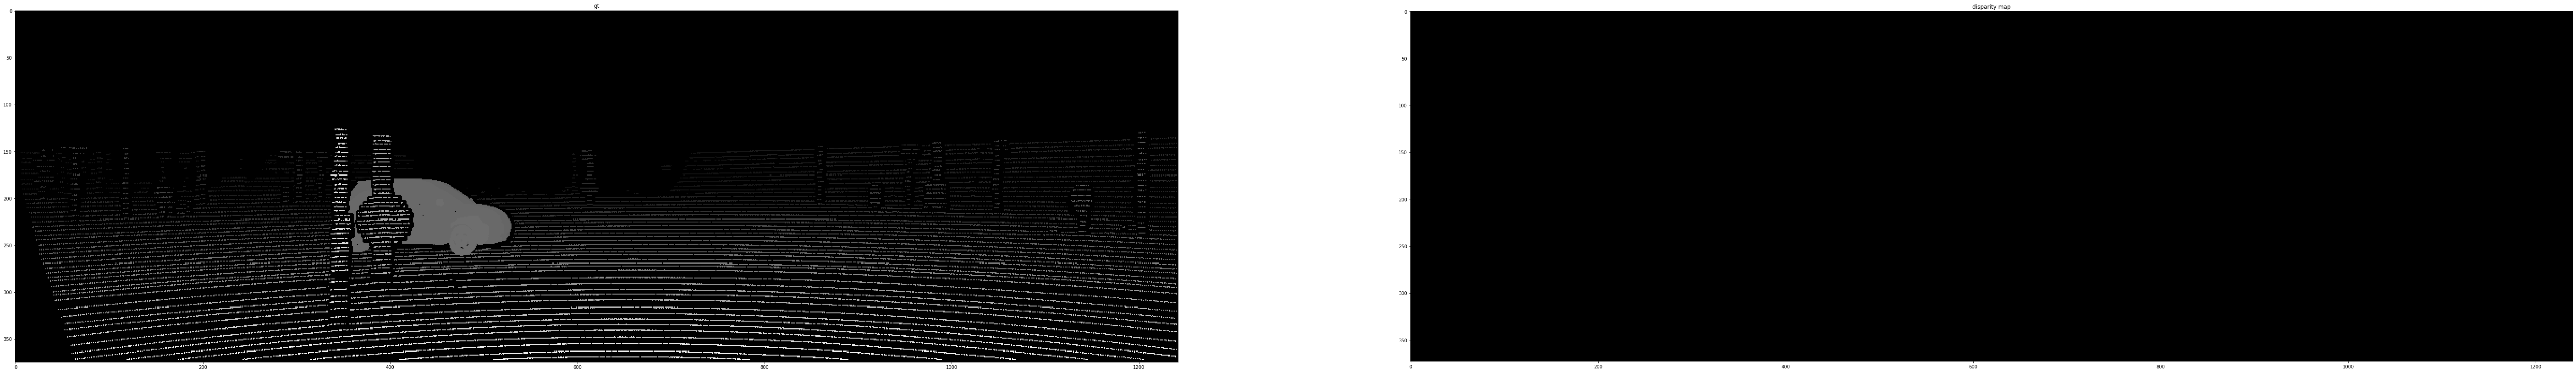


Image KITTI/data_scene_flow/training/image_2\000043_10.png processing finished.

Total execution time = 242.24s

-------------------------------

255
(462520, 64)
False
(462520, 1)
0
(373, 1240)
0
Computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.17s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 29.16s)
	Processing paths south-east and north-west...

KeyboardInterrupt: 

In [31]:
# stereo = cv2.StereoSGBM_create(
#     minDisparity=0,
#     numDisparities=160,
#     blockSize=1,
#     P1=8 * 3 * 3 ** 2,
#     P2=32 * 3 * 3 ** 2,
#     disp12MaxDiff=1,
#     uniquenessRatio=15,
#     speckleWindowSize=0,
#     speckleRange=2,
#     preFilterCap=63,
#     mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
# )

save_recall = []

for image1, image2, gt1, gt2 in zip(glob.glob('KITTI/data_scene_flow/training/image_2/00004[3-9]_10.png'),
                                      glob.glob('KITTI/data_scene_flow/training/image_2/00004[3-9]_10.png'),
                                      glob.glob('KITTI/data_scene_flow/training/disp_noc_0/00004[3-9]_10.png'),
                                      glob.glob('KITTI/data_scene_flow/training/disp_noc_1/00004[3-9]_10.png')):
    
    dawn = t.time()
    
    imgL = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)
    gtL = cv2.imread(gt1, cv2.IMREAD_GRAYSCALE)
    gtR = cv2.imread(gt2, cv2.IMREAD_GRAYSCALE)
    
    print(np.amax(imgL))
    
    # matrix indices to use as "key points"

    indicesL = np.zeros(((imgL.shape[0]-2)*(imgL.shape[1]-2), 2), dtype=np.int64)
    indicesR = np.zeros(((imgR.shape[0]-2)*(imgR.shape[1]-2), 2), dtype=np.int64)
    
    k = 0
    for i in range(1, imgL.shape[0]-1):
        for j in range(1, imgL.shape[1]-1):
            indicesL[k,0], indicesL[k,1] = i, j
            k += 1
    k = 0
    for i in range(1, imgR.shape[0]-1):
        for j in range(1, imgR.shape[1]-1):
            indicesR[k,0], indicesR[k,1] = i, j
            k += 1

    # BRIEF descriptor

    extractor = BRIEF(descriptor_size=64, patch_size=3)
    #brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
   
    extractor.extract(imgL, indicesL)
    descriptorL = extractor.descriptors
    extractor.extract(imgR, indicesR)
    descriptorR = extractor.descriptors
    
#     indicesL, descriptorL = brief.compute(imgL, indicesL)
#     indicesR, descriptorR = brief.compute(imgR, indicesR)

    print(descriptorL.shape)
    print(np.amax(descriptorL))
    
    descL = np.ndarray((descriptorL.shape[0],1), dtype=np.int64)
    descR = np.ndarray((descriptorR.shape[0],1), dtype=np.int64)

    for i in range(descriptorL.shape[0]):
        #descriptorL[i, 0] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
        descL[i] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
        
    for i in range(descriptorR.shape[0]):
        #descriptorR[i, 0] = descriptorR[i].dot(2**np.arange(descriptorR[i].size)[::-1])
        descL[i] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
    
    print(descL.shape)
    print(np.amax(descL))
    
    descriptorL = descL.reshape((imgL.shape[0]-2, imgL.shape[1]-2))
    descriptorR = descL.reshape((imgR.shape[0]-2, imgR.shape[1]-2))
    
    print(descriptorL.shape)
    print(np.amax(descriptorL))

    # SGM matching
    
    print('Computing disparity...')
    
    left_disparity_map, right_disparity_map, left_recall, right_recall = sgm(descriptorL, descriptorR, image1.split('/')[3].split('\\')[1], gt1, gt2)
    #disparity = stereo.compute(descriptorL.astype(np.uint8), descriptorR.astype(np.uint8)).astype(np.float32)/16
    
    left_disparity_norm = np.ndarray((left_disparity_map.shape[0], left_disparity_map.shape[1]))
    right_disparity_norm = np.ndarray((right_disparity_map.shape[0], right_disparity_map.shape[1]))

    left_disparity_norm = cv2.normalize(src=left_disparity_map, dst=left_disparity_norm, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    right_disparity_norm = cv2.normalize(src=right_disparity_map, dst=right_disparity_norm, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    
    save_recall.append(left_recall)
    
    # Visualization
    
#     fig = plt.figure(figsize=(200, 200))
            
#     x = fig.add_subplot(1,2, 1)
#     x.set_title('imgL')
#     plt.imshow(imgL, cmap='gray')

#     y = fig.add_subplot(1,2, 2)
#     y.set_title('imgR')
#     plt.imshow(imgR, cmap='gray')
    
#     plt.show()
    
    fig = plt.figure(figsize=(100, 100))
    
    x = fig.add_subplot(1,2, 1)
    x.set_title('gt')
    plt.imshow(gtL, cmap='gray')

    y = fig.add_subplot(1,2, 2)
    y.set_title('disparity map')
    plt.imshow(left_disparity_norm, cmap='gray')

    plt.show()
    
    dusk = t.time()
    print('\nImage '+image1+' processing finished.')
    print('\nTotal execution time = {:.2f}s'.format(dusk - dawn))
    print('\n-------------------------------\n')